### Advanced Statistics 4 Physics Analysis - A.A. 2023/24
## Determination of the muon magnetic moment
Pietro Bernardi (2097494), Tomàs Mezquita Fernandez (2109239)

#### Abstract
Muons are long-lived particles, produced in the decays of pions and kaons originating from the interactions of primary cosmic rays with the Earth's atmosphere. Muons decay via weak interactions and, according to [1], their lifetime is:
$$
2.1969811 \pm 0.0000022\hspace{0.2cm} \mu s
$$
Moreover, parity violation is also present in the decay which proceeds as follows:
$$
\mu^+ \rightarrow e^+ + \nu_e + \bar{\nu}_\mu \hspace{0.5cm} and \hspace{0.5cm} \mu^- \rightarrow e^- + \bar{\nu}_e + \nu_\mu
$$
According to [2] and [3], simple experiments can be performed measuring muons that decay in a thick absorber. If the absorber is immersed in a constant magnetic field, the muon spin, before the decay, proceeds with a frequency:
$$
\omega = g_\mu \cdot\frac{e B}{2m_\mu}
$$
The decay proceeds mainly along the direction of the spin of the muon and therefore, if the muon is (partly) polarized, the detected signal varies with time with $\omega$, spin precession angular frequency.

Analyzing the data collected without and with the magnetic field, setup a Markov Chain Monte Carlo that allows to extract the muon lifetime $t_\mu$ ($B$ off) and the muon precession frequency $\omega$ ($B$ on).

### 1. Experimental setup

#### 1.1 Introduction
The experimental setup is similar to the one described in [2,3]:
<div align="center"><img src="./img/bosnar.jpg" width=500></div>
A cosmic muon enters the scintillator and the signal is collected and amplified by PMTs. If the muon is absorbed in the absorber material, depending on its charge ($\mu^+$ or $\mu^-$) two different behaviours can be expected:

1. A positive muon, when it is stopped in the material, decays as if it were a free particle, emitting a positron, an electron neutrino and a muonic anti-neutrino.

2. A negative muon can instead undergo:
   * a capture reaction with a nucleus, releasing a neutron and neutrino.
   * a radiative transition: the muon acts as if it were an electron in an energy level and the transition energy is released as a photon.
   * a decay into an electron, an electronic anti-neutrino and a muonic neutrino.

The processes involving the negative muon proceed much more quickly than the free-particle lifetime, especially for thick absorbers.

#### 1.2 Principle of measurement
When a muon (or any other sufficiently energetic particle) interacts with the scintillator, a signal is generated and amplified. If that signal passes an initial selection, a TDC (or TAC) starts measuring the time between this instant and the next signal it will receive by the scintillator. In fact, when the muon decays, the decay particle (electron or positron) can interact with the scintillator (if the decay occurrs in the detectable region) and thus provide a stop signal. In this way it is possible to measure the time between the muon arrival and its decay in the material, obtaining a count distribution in time.

### 2. Analysis of the lifetime data
#### 2.1 Introduction

In [2]:
# loading libraries
library(rjags)
library(dplyr)
library(parallel)

In [3]:
options(repr.plot.quality=100)
options(repr.plot.width=8)
options(repr.plot.height=7)
options(repr.plot.res=200)

In [4]:
# getting a list of all the lifetime datafiles
files <- list.files(path = "./data_muong2/data/lifetime/2023_24", pattern = "*.dat$", full.names = TRUE)

In [5]:
# function to read the files    
extract_data_from_file <- function(file) { 
  # code to extract data from file 
  data <- readLines(file) 
  # returning as numeric (each line is an integer ADC reading) 
  return(as.numeric(data))
} 

# launching a cluster to read the files rapidly
cl <- makeCluster(detectCores())
results <- parLapply(cl, files, extract_data_from_file) 
stopCluster(cl) 
  
# data is now inside "results" as a multi-indexed list, so results[[i]] = contents of the i-th file

The first thing we did was to convert the time measurements into a time spectrum with several time-channels, counting the events in each bin and thus obtaining a count distribution. In order to do this, we used the time calibration of the ADC:
$$
t [\mu s] = \frac{1}{1000}\cdot\left(p_0 + p1\cdot t [ADC]\right)
$$
where $p_0 = 7.388\pm 4.397\hspace{0.2cm}ns$ and $p_1 = 14.9\pm0.1\hspace{0.2cm}ns$. The resulting distribution is shown below.


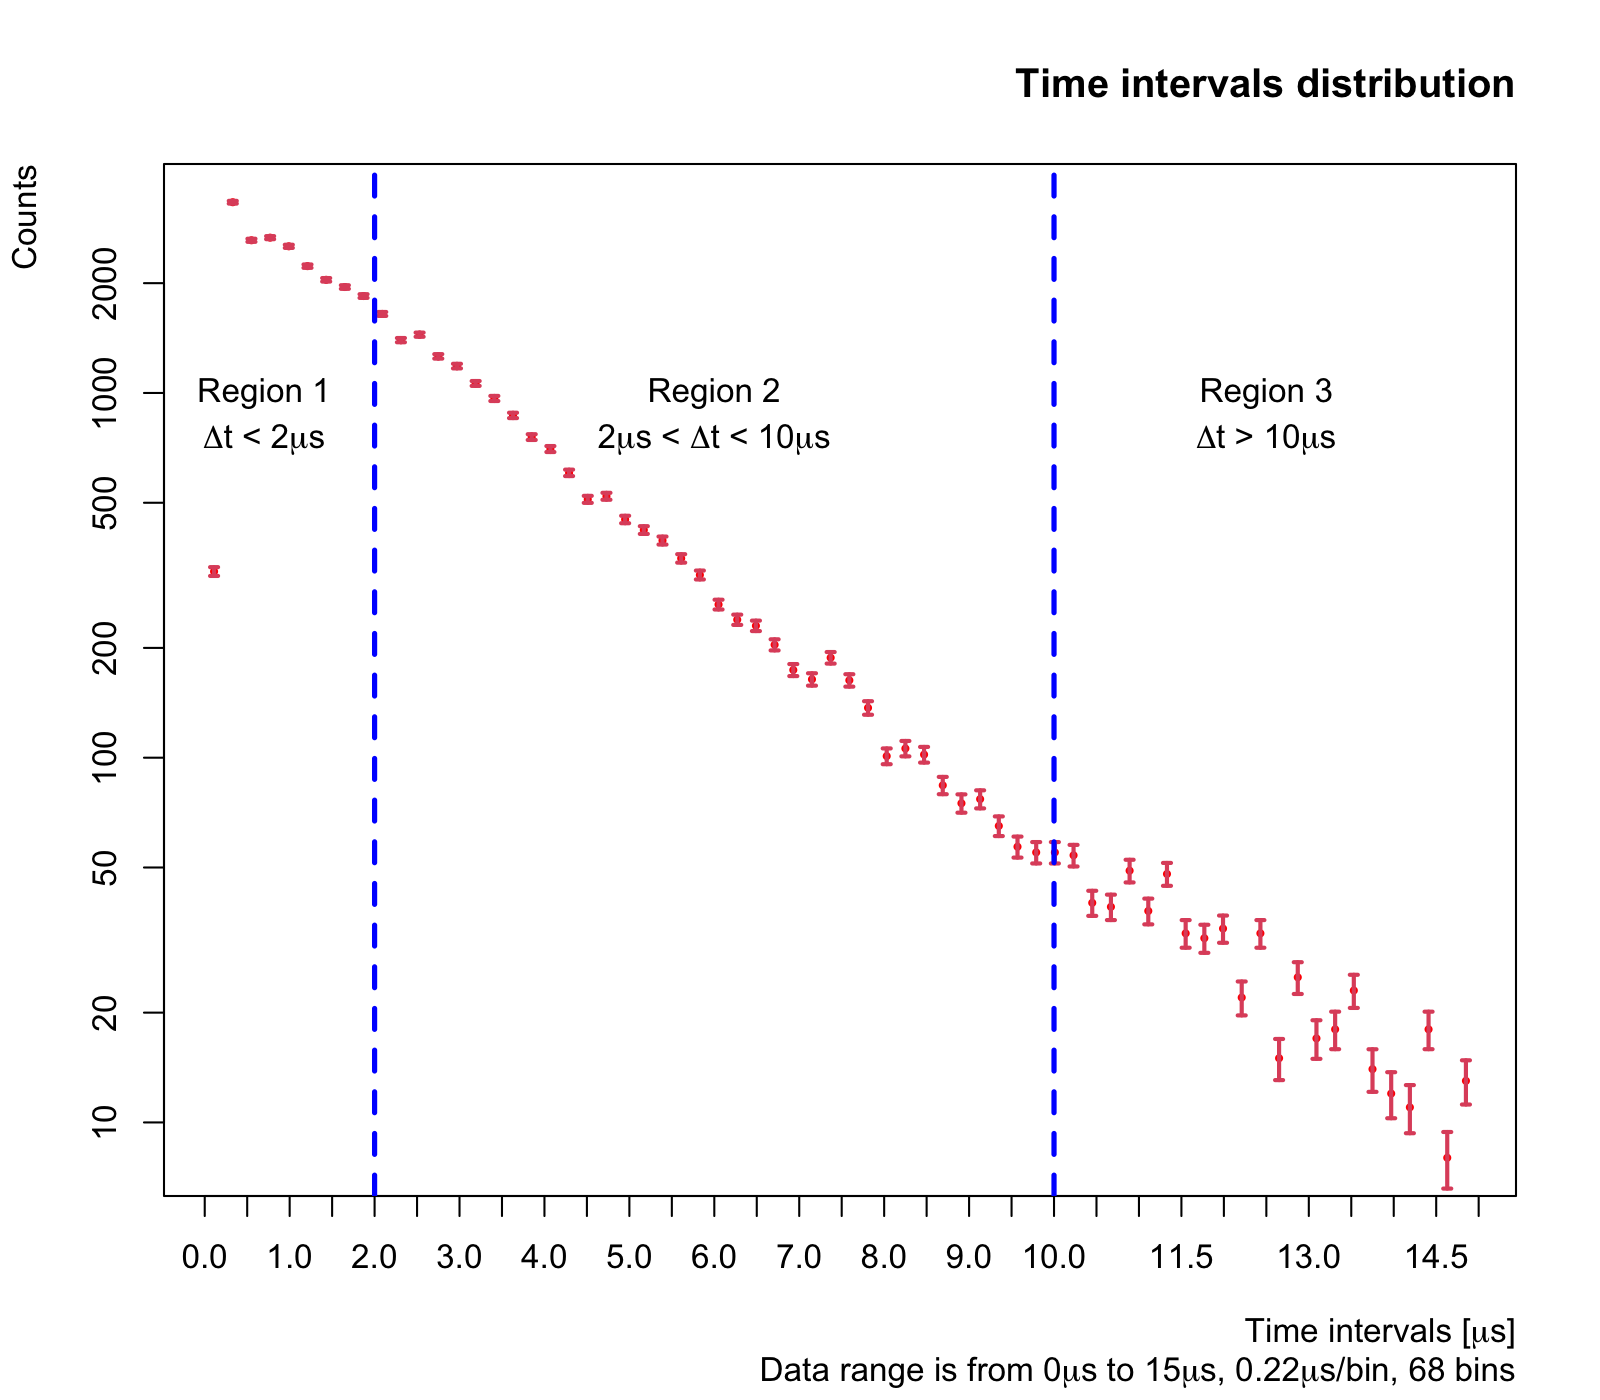

In [6]:
# conversion to microseconds and binning
r <- (unlist(results)*14.9 + 7.387)/1000.
h_breaks <- seq(from=0, to=15, by=0.22)
h <- hist(r, breaks=h_breaks, plot=F)

# plotting the distribution in logarithmic scale
plot(h$mids, h$counts, log='y', xaxt='n', pch=19, cex=0.4, col='red',
     xlab=expression(paste("Time intervals [",mu,"s]")),
     ylab="Counts",
     main="Time intervals distribution",
     sub=expression(paste("Data range is from 0",mu,"s to 15",mu,"s, 0.22",mu,"s/bin, 68 bins")),
     adj=1
)
axis(1, at = seq(0, 15, by = 0.5), las=1)

# computing bin-errors as Poisson
errs <- sqrt(h$counts)
arrows(h$mids,h$counts+errs/2,h$mids,h$counts-errs/2,col=2,angle=90,length=0.02,code=3, lwd=2)
abline(v=2.,col='blue',lty='dashed',lwd=2.5)
abline(v=10,col='blue',lty='dashed',lwd=2.5)

# placing some text
text(.7, 1000, "Region 1")
text(.7, 750, expression(paste(Delta,"t < 2",mu,"s")))
text(6, 1000, "Region 2")
text(6,750, expression(paste("2",mu,"s < ",Delta,"t < 10",mu,"s")))
text(12.5, 1000, "Region 3")
text(12.5,750, expression(paste(Delta,"t > 10",mu,"s")))

The figure shows the time distribution of the time intervals with the vertical axis scale set to logarithmic. We spot three regions with different slopes. A first region extending from $0\mu s$ to $\approx 2\mu s$, a central region from $\approx 2\mu s$ to $\approx 9 \mu s$ and a final region extending from $9\mu s$ towards the longest lifetimes.

According to [2,3] we expect the data to be distributed as:
$$
N_0\cdot\exp{\left(-\frac{t}{\tau}\right)} + C
$$
which is an off-setted exponential. We can see that at longer times the data distribution seems to bend and probably stabilize around a constant value $C$ which will be our background level. According to [4] this would mainly be due to <i>singles</i>, that is when a muon triggers the TDC but no subsequent stop signal is received and the TDC is stopped either by another muon entering the scintillator or by a self-reset due to a stop signal failing to register in the allowed time window.

So, starting from region 2 we can see that the slope is fairly constant and then gradually bends when entering the third region. While this behaviour was expected, when it comes to region 1 instead we can spot a different slope.

Since this is determined by the constant inside the exponential, a different slope might indicate that different kinds of physical processes are at work. Some sources (e.g. [5]) do indeed suggest several origins for the events that are registered at small time intervals, for instance:
1. Early time intervals ($< 1 \mu s$):
   * signals due to particle showers induced in the scintillator due to $\mu$ passage.
   * signals due to atomic capture of $\mu^-$ by the absorber or the scintillator. The trapped $\mu^-$ decay emitting electrons or photons due to induced atomic transitions.
2. Later time intervals ($\approx 1 \mu s$ range): PMT after-pulsing. The time constant of these pulses is reported to be usually in the order of the $\mu s$.

Since we didn't have access to the specifics of the experimental apparatus, we decided, for safety, to not consider time intervals shorter than $2 \mu s$ in order to attenuate these effects.

In [7]:
# function to pre-process the data (allows to select a range)
preproc <- function(r, data_range) {
    filt <- (r >= data_range[1]) & (r <= data_range[2])
    return(r[filt])
}

# function to get the compatibility between an estimate and the reference
comp <- function(estimate, reference) {
    return (abs(estimate[1]-reference[1])/sqrt(estimate[2]^2 + reference[2]^2))
}

#### 2.2 Model and JAGS implementation
Since we have a count distribution and since each bin that is counting events is independent from all the others, we considered a Poisson distribution inside each bin, so that the total likelihood would be:
$$
\mathcal{L}(\lbrace Y_i\rbrace|\lbrace\lambda_i\rbrace) = \prod_{i=1}^{n} \exp{(-\lambda_i)}\frac{\lambda_i^{Y_i}}{Y_i!}
$$
where $Y_i$ are the counts in the $i$-th bin and $\lambda_i$ is the expected number of events in that bin, that will be given by:
$$
\lambda_i = N\cdot\exp{\left(-\frac{t_i}{\tau}\right)} + C
$$
where we considered $t_i$ as the center of the $i-th$ bin. This is thus translated into a JAGS model writing its correspondent BUGS code:
```
model {
 # likelihood
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau);
  lambda[i] <- X*prob[i] + C
  Y[i] ~ dpois(lambda[i]);
 }

 # priors for the parameters
 tau ~ dnorm(2,1);
 X ~ dunif(0,1e5);
 C ~ dunif(0,200);
}
```
As we can see, the prior on $\tau$ is not much informative at this stage.

In [8]:
# preparing the input for JAGS
jm.input <- NULL
jm.input$t <- h$mids
jm.input$Y <- h$counts
jm.input$n <- length(h$mids)
# filtering so that we consider only 2 and 3 regions
filt = jm.input$t >= 2
jm.input$t <- jm.input$t[filt]
jm.input$Y <- jm.input$Y[filt]
jm.input$n <- length(jm.input$t)
jm.input

$t
 [1]  2.09  2.31  2.53  2.75  2.97  3.19  3.41  3.63  3.85  4.07  4.29  4.51
[13]  4.73  4.95  5.17  5.39  5.61  5.83  6.05  6.27  6.49  6.71  6.93  7.15
[25]  7.37  7.59  7.81  8.03  8.25  8.47  8.69  8.91  9.13  9.35  9.57  9.79
[37] 10.01 10.23 10.45 10.67 10.89 11.11 11.33 11.55 11.77 11.99 12.21 12.43
[49] 12.65 12.87 13.09 13.31 13.53 13.75 13.97 14.19 14.41 14.63 14.85

$Y
 [1] 1647 1396 1445 1260 1185 1062  966  868  757  702  604  511  521  450  421
[16]  394  352  317  263  239  230  204  174  164  188  163  137  101  106  102
[31]   84   75   77   65   57   55   55   54   40   39   49   38   48   33   32
[46]   34   22   33   15   25   17   18   23   14   12   11   18    8   13

$n
[1] 59

In [9]:
model.lifetime <- "
model {
 # likelihood
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau);
  lambda[i] <- X*prob[i] + C
  Y[i] ~ dpois(lambda[i]);
 }

 # priors for the parameters
 tau ~ dnorm(2,1);
 X ~ dunif(0,1e5);
 C ~ dunif(0,200);
}
"

In [10]:
jm <- jags.model(textConnection(model.lifetime), data = jm.input)
update(jm,5000)
full.chain <- coda.samples(jm, c("tau","X","C"), n.iter=30000)
summary(full.chain)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 59
   Unobserved stochastic nodes: 3
   Total graph size: 423

Initializing model




Iterations = 6001:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean       SD  Naive SE Time-series SE
C      8.712  1.34649 0.0077739      0.0282904
X   4353.744 91.63790 0.5290717      2.6410869
tau    2.189  0.02585 0.0001492      0.0007718

2. Quantiles for each variable:

        2.5%      25%      50%      75%   97.5%
C      6.137    7.783    8.696    9.615   11.39
X   4179.821 4290.353 4352.025 4413.852 4538.55
tau    2.139    2.172    2.189    2.207    2.24


In [11]:
full.chain.df <- as.data.frame(as.mcmc(full.chain))

We can examine the chains diagnostic plots here below.

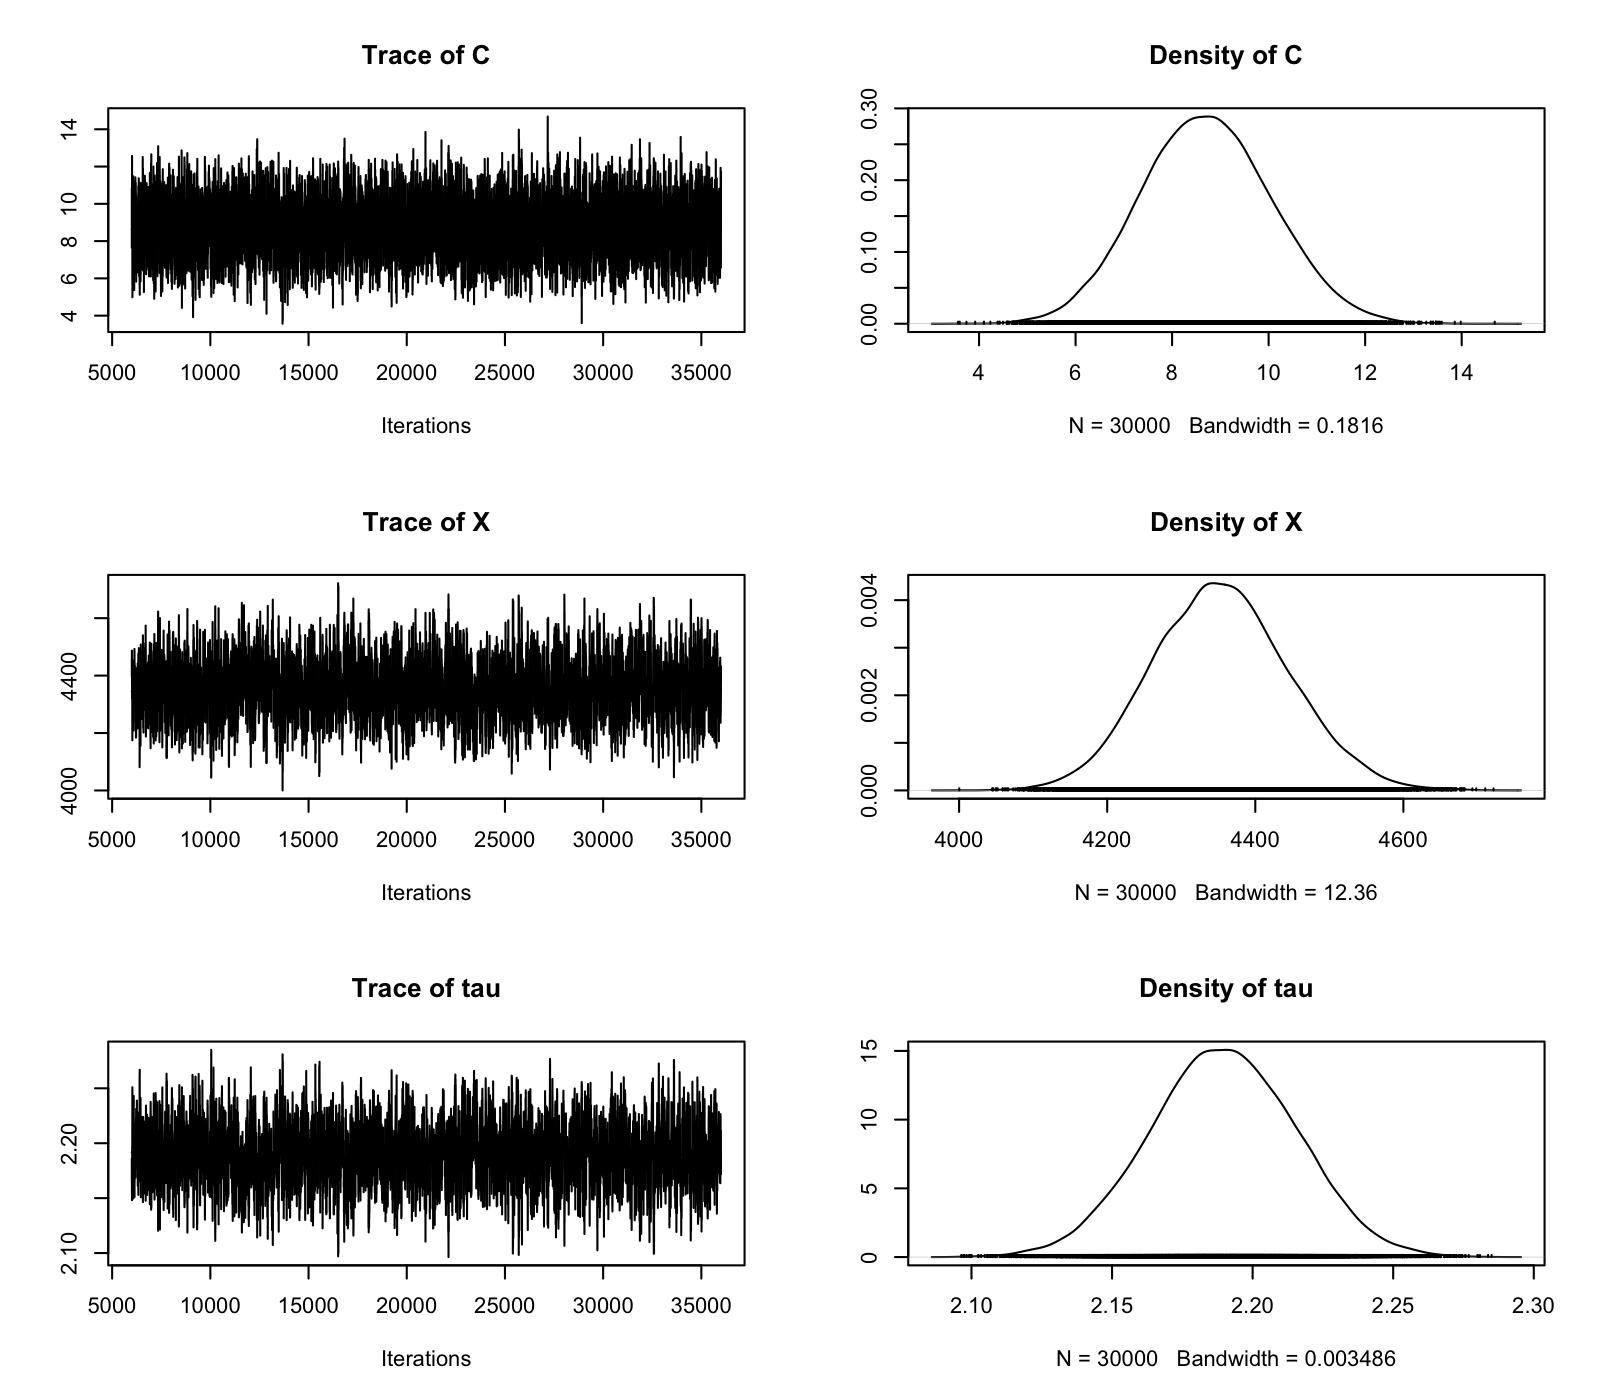

In [12]:
plot(full.chain)

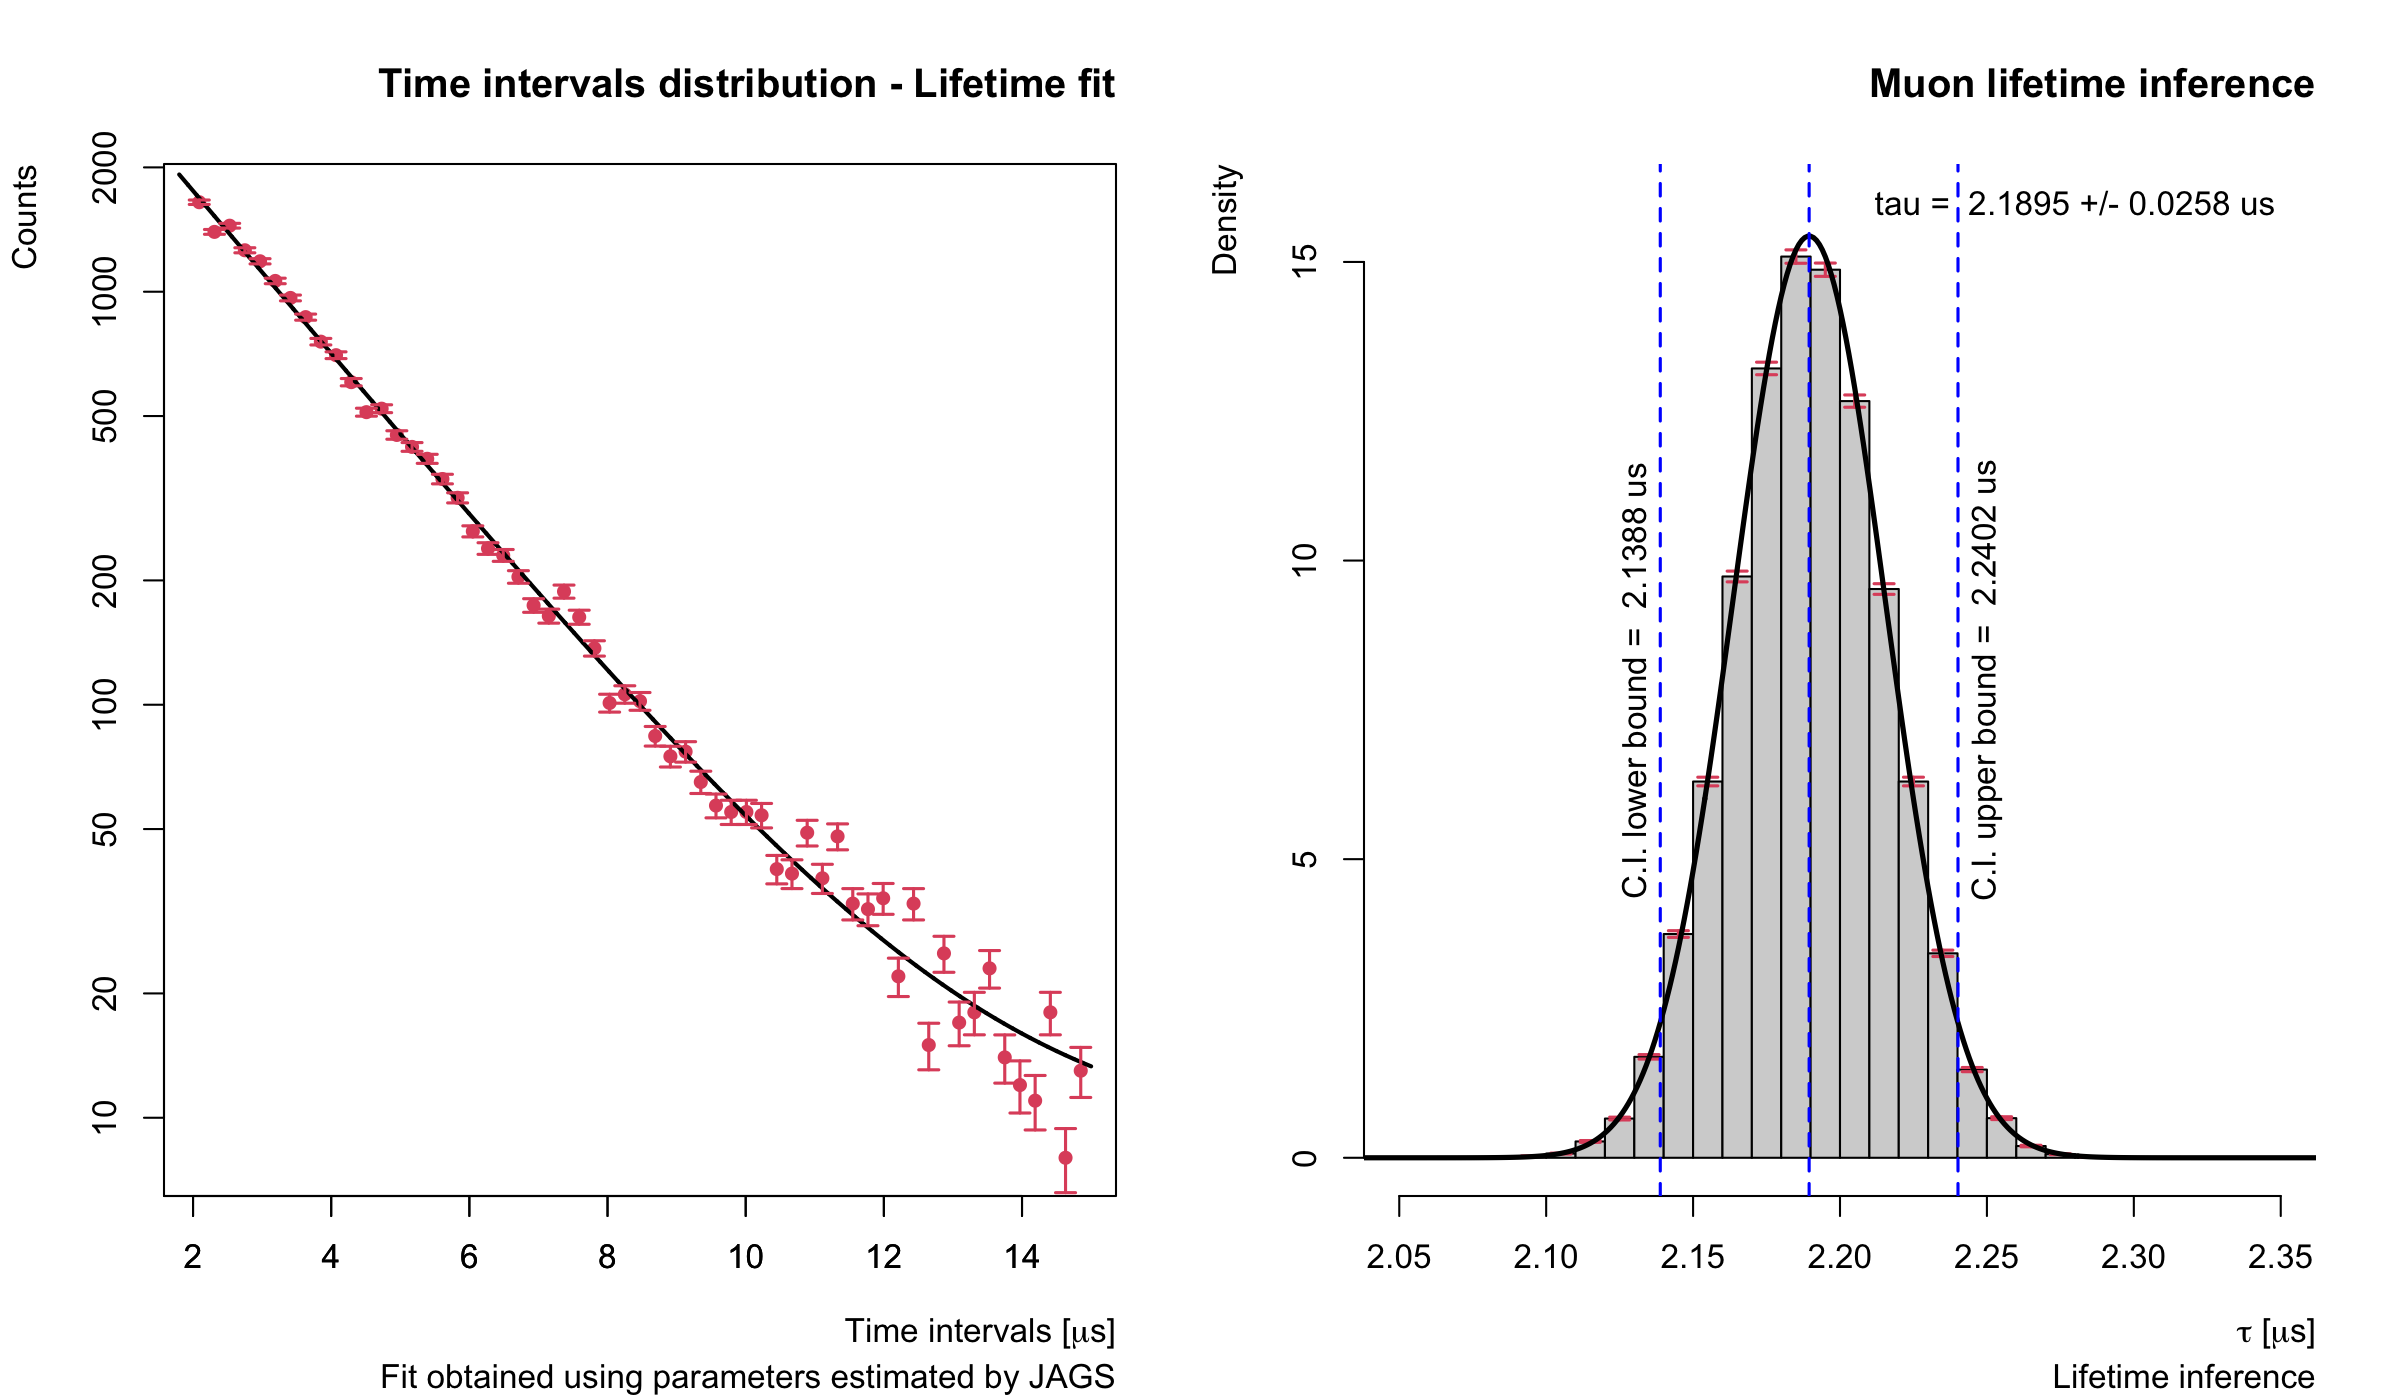

In [13]:
# plotting options
options(repr.plot.width=12)
options(repr.plot.height=7)
par(mfrow=c(1,2))

# getting the inference
full.mcT <- mean(full.chain.df$tau)
full.mcT.sigma <- sd(full.chain.df$tau)
full.mcC <- mean(full.chain.df$C)
full.mcX <- mean(full.chain.df$X)

# plotting the results
plot(jm.input$t, jm.input$Y, log='y', pch=19, cex=0.8, col=2,
     xlab=expression(paste("Time intervals [",mu,"s]")),
     ylab="Counts",
     main="Time intervals distribution - Lifetime fit",
     adj=1,
     sub="Fit obtained using parameters estimated by JAGS"
    )
axis(1, at = seq(0, 15, by = 2), las=1)
xpt <- seq(from=1.8, to=15, by=1/1000)
ypt <- full.mcX*exp(-xpt/full.mcT) + full.mcC
lines(xpt, ypt, lwd=2)
# arrows for the errors of the points in the plot
arrows(jm.input$t,jm.input$Y+sqrt(jm.input$Y)/2,jm.input$t,jm.input$Y-sqrt(jm.input$Y)/2,col=2,angle=90,length=0.05,code=3,lwd=1.5)

# plotting the inference on tau
htau <- hist(full.chain.df$tau, prob=T, main="Muon lifetime inference", xlim=c(2.05,2.35), ylim=c(0,16),
     adj=1,
     ylab="Density",
     xlab=expression(paste(tau," [",mu,"s]")),
     sub="Lifetime inference"
     )
# Calculate the error bars for the hist
scale_factor <- htau$density/htau$counts
error <- sqrt(htau$counts)*scale_factor
# Plot the error bars on the hist
min.arr <- htau$density-error/2
max.arr <- htau$density+error/2
suppressWarnings(arrows(htau$mids,max.arr,htau$mids,min.arr,col=2,angle=90,length=0.05,code=3,lwd=1.5))


# plot the gaussian
x <- seq(from=1.9, to=2.5, by=1/1000)
lines(x, dnorm(x, full.mcT, sd(full.chain.df$tau)), lwd=2.5)

# computing the 95% C.I.
full.ci.lower <- qnorm(0.025, full.mcT, sd(full.chain.df$tau))
full.ci.upper <- qnorm(0.025, full.mcT, sd(full.chain.df$tau), lower.tail=F)
abline(v=full.ci.lower, lwd=1.5, lty='dashed', col='blue')
abline(v=full.ci.upper, lwd=1.5, lty='dashed', col='blue')
abline(v=full.mcT, lwd=1.5, lty='dashed', col='blue')
text(2.13,8,paste("C.I. lower bound = ",round(full.ci.lower,4),"us"),srt=90)
text(2.25,8,paste("C.I. upper bound = ",round(full.ci.upper,4),"us"),srt=90)
text(2.28,16,paste("tau = ",round(full.mcT,4),"+/-",round(sd(full.chain.df$tau),4),"us"))

The figure above shows the experimental data and the interpolating curve whose parameters have been estimated by JAGS. We obtain an estimate for the lifetime $\tau$ which is in good compatibility with the literature reference [1]. The compatibility metric we use is:
$$
    C = \frac{\left|\tau_{exp}-\tau_0\right|}{\sqrt{\sigma(\tau_{exp})^2 + \sigma(\tau_0)^2}}
$$

In [14]:
compat2to15 <- comp(c(full.mcT, sd(full.chain.df$tau)), c(2.1969811,0.0000022))
compat2to15

[1] 0.2896332

#### 2.3 A more aggressive restriction
Some Authors like [4], suggested to consider data only for $t \leq 5 \mu s$. We try this approach to see whether it improves results using now as a prior for the background $C$ a gaussian distribution with mean and $\sigma$ given by the previous iteration of the model. The model is thus updated as:
```
model {
 # likelihood
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau);
  lambda[i] <- X*prob[i] + C
  Y[i] ~ dpois(lambda[i]);
 }

 # priors for the parameters
 tau ~ dnorm(2,1);
 X ~ dunif(0,1e5);
 C ~ dnorm(8.705, 0.57);
}
```


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 3
   Total graph size: 116

Initializing model




Iterations = 6001:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean        SD  Naive SE Time-series SE
C      8.677   1.33393 0.0077014       0.009969
X   3969.456 141.12026 0.8147582       5.523005
tau    2.193   0.05238 0.0003024       0.002095

2. Quantiles for each variable:

        2.5%      25%      50%      75%    97.5%
C      6.103    7.772    8.679    9.578   11.300
X   3702.301 3874.189 3965.568 4062.290 4258.426
tau    2.093    2.157    2.193    2.228    2.299


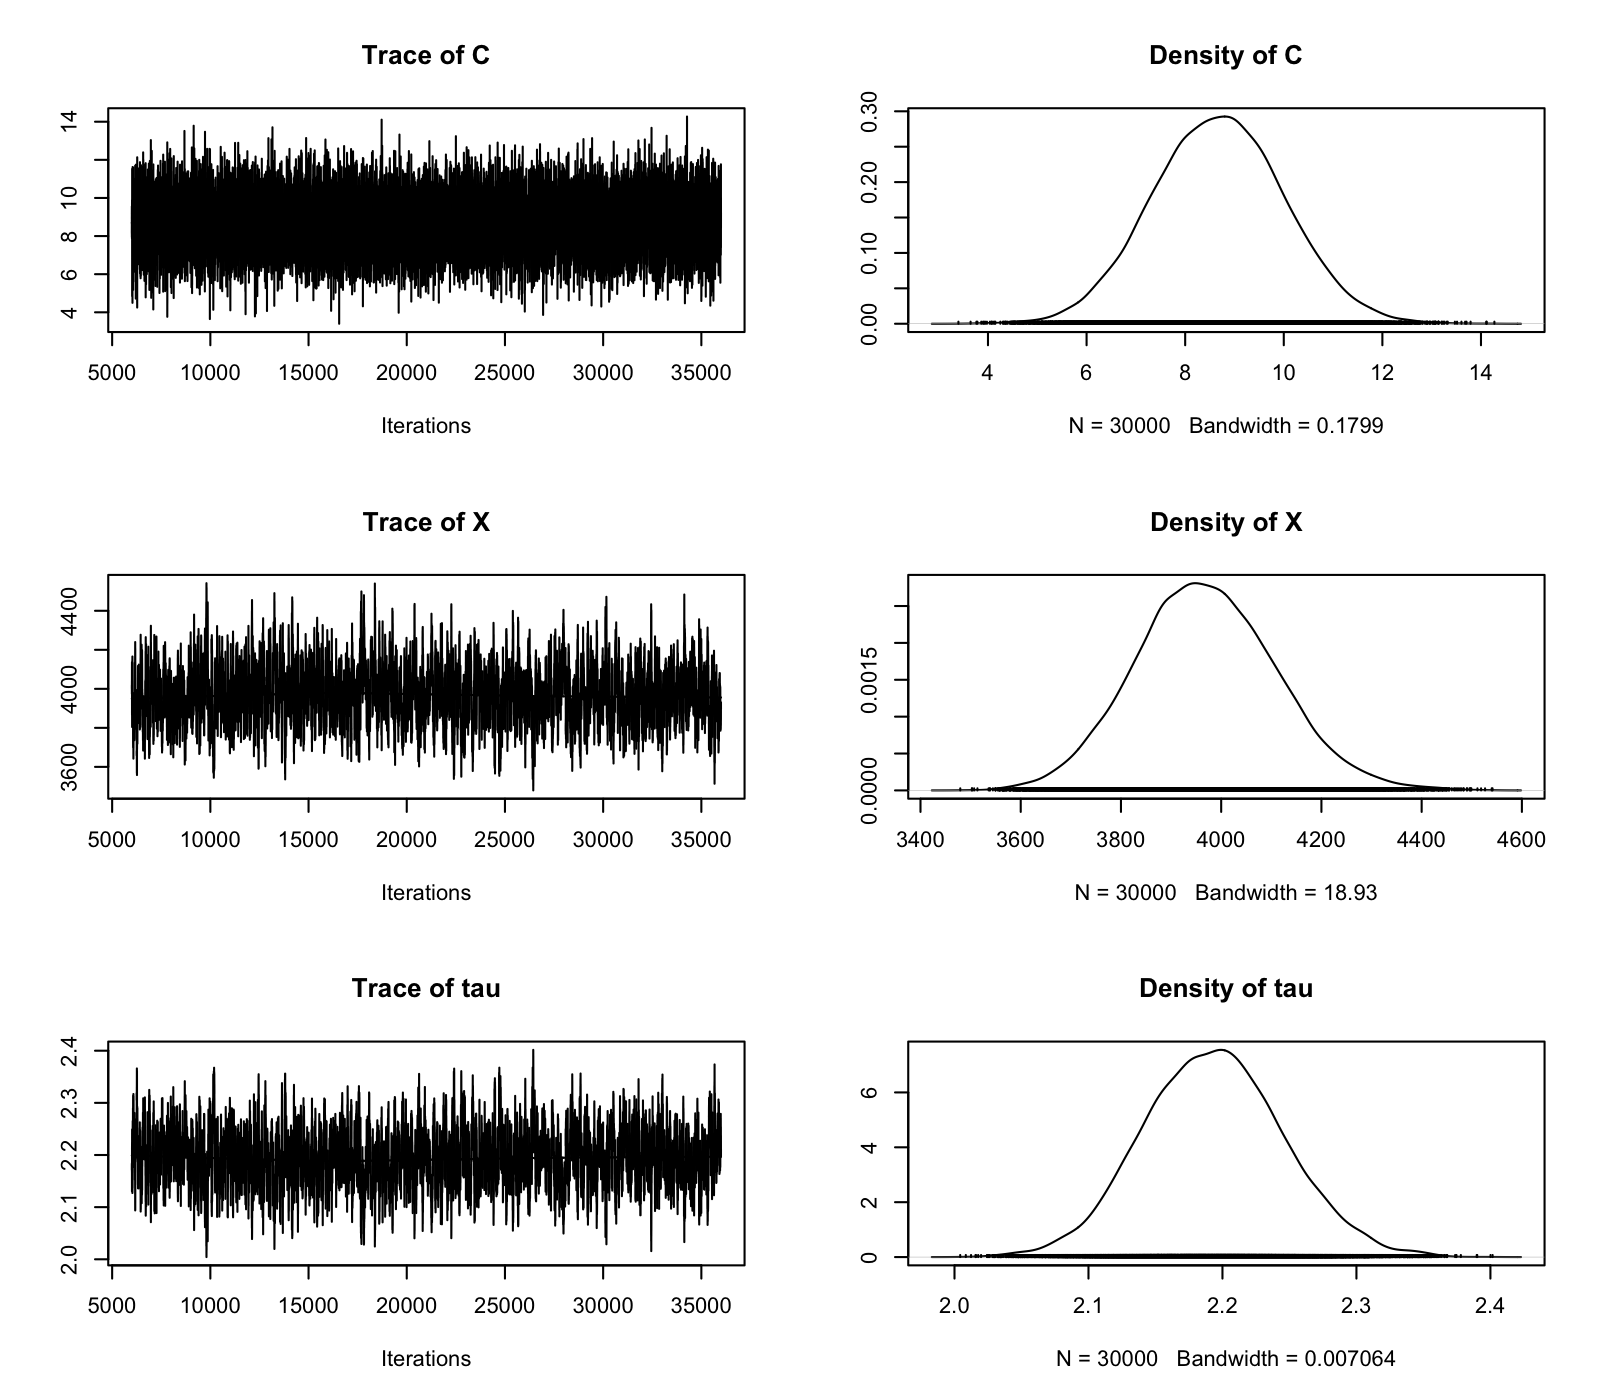

In [15]:
options(repr.plot.width=8)
options(repr.plot.height=7)

# restricting the data and rebinning in order to have approximately the same time-step inside the range
# as we had before so that we may better compare the results
newdata <- preproc(r, c(2,5))
newh <- hist(newdata, breaks=16, plot=F)

# preparing the input for jags
jm.input <- NULL
jm.input$t <- newh$mids
jm.input$Y <- newh$counts
jm.input$n <- length(newh$mids)

# updating the model
model.lifetime <- "
model {
 # likelihood
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau);
  lambda[i] <- X*prob[i] + C
  Y[i] ~ dpois(lambda[i]);
 }

 # priors for the parameters
 tau ~ dnorm(2,1);
 X ~ dunif(0,1e5);
 C ~ dnorm(8.705, 0.57);
}
"

# running the model
jm <- jags.model(textConnection(model.lifetime), data = jm.input)
update(jm,5000)
red.chain <- coda.samples(jm, c("tau","X","C"), n.iter=30000)
summary(red.chain)
red.chain.df <- as.data.frame(as.mcmc(red.chain))

# and printing the chain
plot(red.chain)

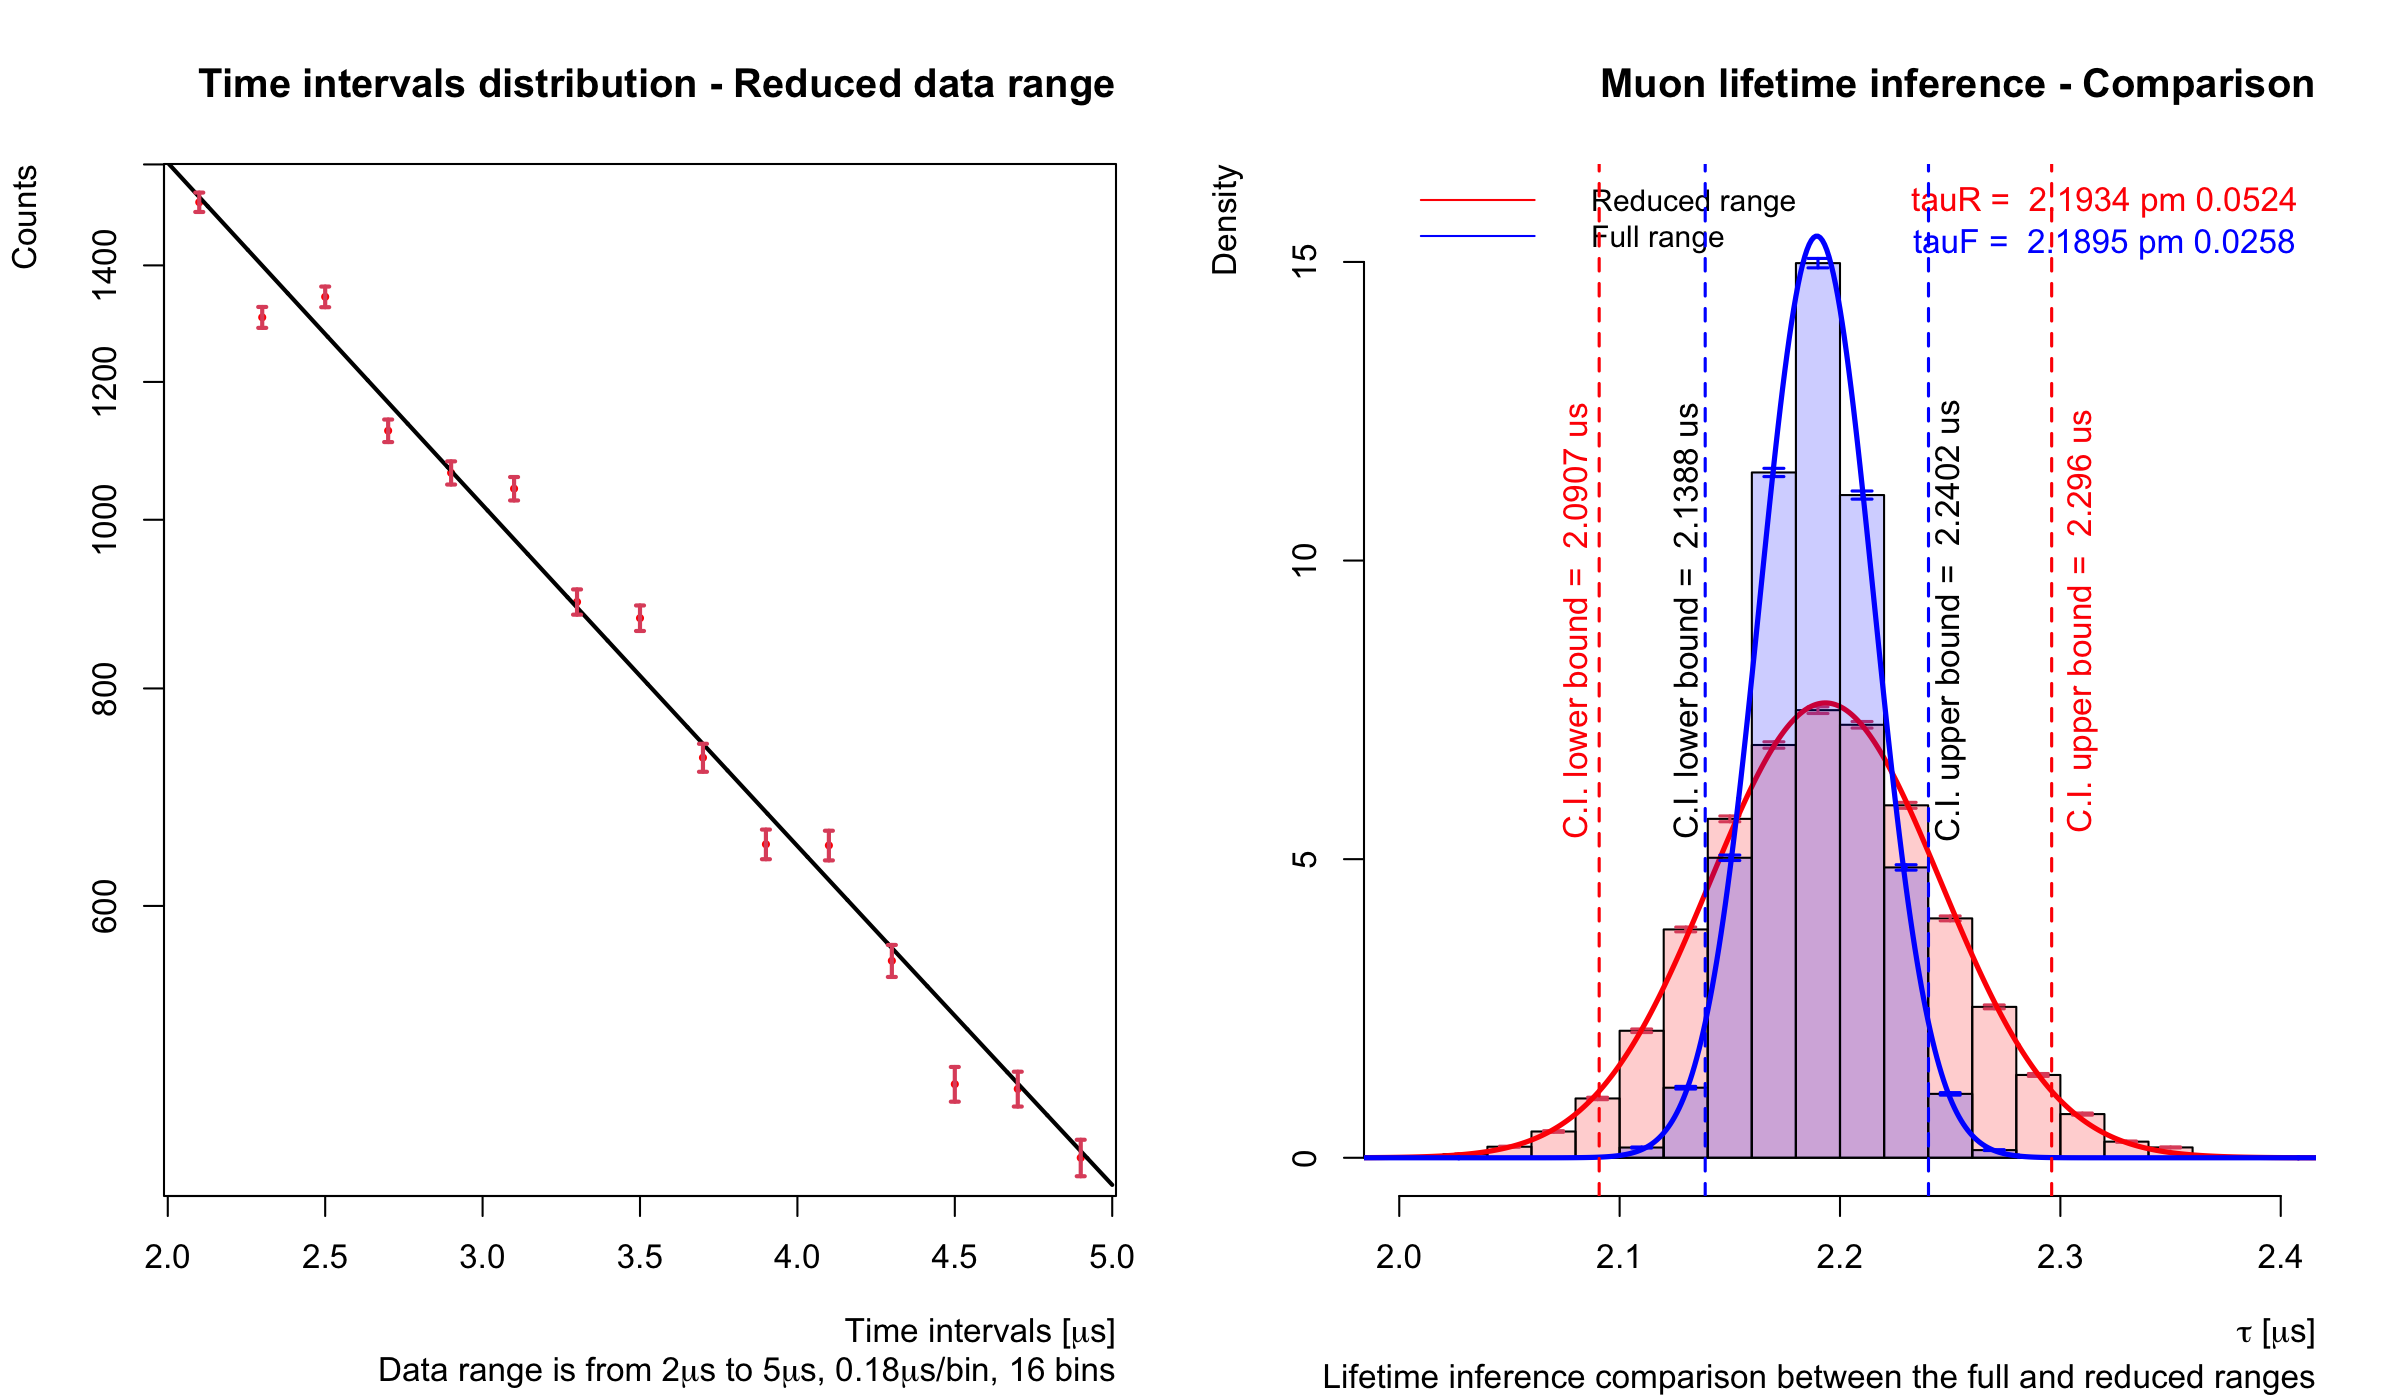

In [16]:
# showing the results
options(repr.plot.width=12)
options(repr.plot.height=7)
par(mfrow=c(1,2))
plot(newh$mids, newh$counts, log='y', xaxt='n', pch=19, cex=0.4, col='red',
     xlab=expression(paste("Time intervals [",mu,"s]")),
     ylab="Counts",
     main="Time intervals distribution - Reduced data range",
     sub=expression(paste("Data range is from 2",mu,"s to 5",mu,"s, 0.18",mu,"s/bin, 16 bins")),
     adj=1
)
axis(1, at = seq(2, 5, by = 0.5), las=1)
# obtaining inference
red.mcT = mean(red.chain.df$tau)
red.mcT.sigma <- sd(red.chain.df$tau)
red.mcC = mean(red.chain.df$C)
red.mcX = mean(red.chain.df$X)
# plotting
xpt <- seq(from=2, to=5, by=1/1000)
ypt <- red.mcX*exp(-xpt/red.mcT) + red.mcC
lines(xpt, ypt, lwd=2)
errs <- sqrt(newh$counts)
arrows(newh$mids,newh$counts+errs/2,newh$mids,newh$counts-errs/2,col=2,angle=90,length=0.02,code=3, lwd=2)

# plotting the inference on tau
htau.red <- hist(red.chain.df$tau, prob=T, main="Muon lifetime inference - Comparison", xlim=c(2.,2.4), ylim=c(0,16),
     adj=1,
     ylab="Density",
     xlab=expression(paste(tau," [",mu,"s]")),
     sub="Lifetime inference comparison between the full and reduced ranges",
     col=rgb(1, 0, 0, alpha=0.2),
     )
# Calculate the error bars
scale_factor.red <- htau.red$density/htau.red$counts
error.red <- sqrt(htau.red$counts)*scale_factor.red
# Plot the error bars on the hist
min.arr.red <- htau.red$density-error.red/2
max.arr.red <- htau.red$density+error.red/2
suppressWarnings(arrows(htau.red$mids,max.arr.red,htau.red$mids,min.arr.red,col=2,angle=90,length=0.05,code=3,lwd=1.5))

x <- seq(from=1.9, to=2.5, by=1/1000)
lines(x, dnorm(x, red.mcT, sd(red.chain.df$tau)), lwd=2.5, col='red')
# super-imposing old
htau <- hist(full.chain.df$tau, prob=T, add=T, breaks=10, col=rgb(0, 0, 1, alpha=0.2))
lines(x, dnorm(x, full.mcT, sd(full.chain.df$tau)), lwd=2.5, col='blue')
legend("topleft", legend=c("Reduced range", "Full range"),
       col=c("red", "blue"), lty=c(1,1), cex=0.9, box.lty=0)
# Calculate the error bars
scale_factor <- htau$density/htau$counts
error <- sqrt(htau$counts)*scale_factor
# Plot the error bars on the hist
min.arr <- htau$density-error/2
max.arr <- htau$density+error/2
suppressWarnings(arrows(htau$mids,max.arr,htau$mids,min.arr,col='blue',angle=90,length=0.05,code=3,lwd=1.5))

# computing the 95% C.I. for the reduced
red.ci.lower <- qnorm(0.025, red.mcT, sd(red.chain.df$tau))
red.ci.upper <- qnorm(0.025, red.mcT, sd(red.chain.df$tau), lower.tail=F)
abline(v=red.ci.lower, lwd=1.5, lty='dashed', col='red')
abline(v=red.ci.upper, lwd=1.5, lty='dashed', col='red')
text(2.08,9,paste("C.I. lower bound = ",round(red.ci.lower,4),"us"),srt=90,col='red')
text(2.31,9,paste("C.I. upper bound = ",round(red.ci.upper,4),"us"),srt=90,col='red')
text(2.32,16,paste("tauR = ",round(red.mcT,4),"pm",round(sd(red.chain.df$tau),4)),col='red')

# showing the 95% C.I. for the full
abline(v=full.ci.lower, lwd=1.5, lty='dashed', col='blue')
abline(v=full.ci.upper, lwd=1.5, lty='dashed', col='blue')
text(2.13,9,paste("C.I. lower bound = ",round(full.ci.lower,4),"us"),srt=90)
text(2.25,9,paste("C.I. upper bound = ",round(full.ci.upper,4),"us"),srt=90)
text(2.32,15.3,paste("tauF = ",round(full.mcT,4),"pm",round(sd(full.chain.df$tau),4)),col='blue')


In [17]:
compat2to5 <- comp(c(red.mcT, sd(red.chain.df$tau)), c(2.1969811,0.0000022))
compat2to5

[1] 0.06868343

#### 2.4 Restricting data on region 2 only
We then investigated region 2 only, still using the value of the background computed in the first run.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 20
   Unobserved stochastic nodes: 3
   Total graph size: 151

Initializing model




Iterations = 6001:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean        SD  Naive SE Time-series SE
C      8.665   1.30926 0.0075590      0.0113234
X   7962.433 158.90383 0.9174317      4.0230086
tau    2.194   0.02253 0.0001301      0.0005687

2. Quantiles for each variable:

        2.5%      25%      50%      75%    97.5%
C      6.109    7.770    8.665    9.548   11.262
X   7661.741 7853.421 7959.096 8068.268 8285.462
tau    2.149    2.179    2.194    2.210    2.238


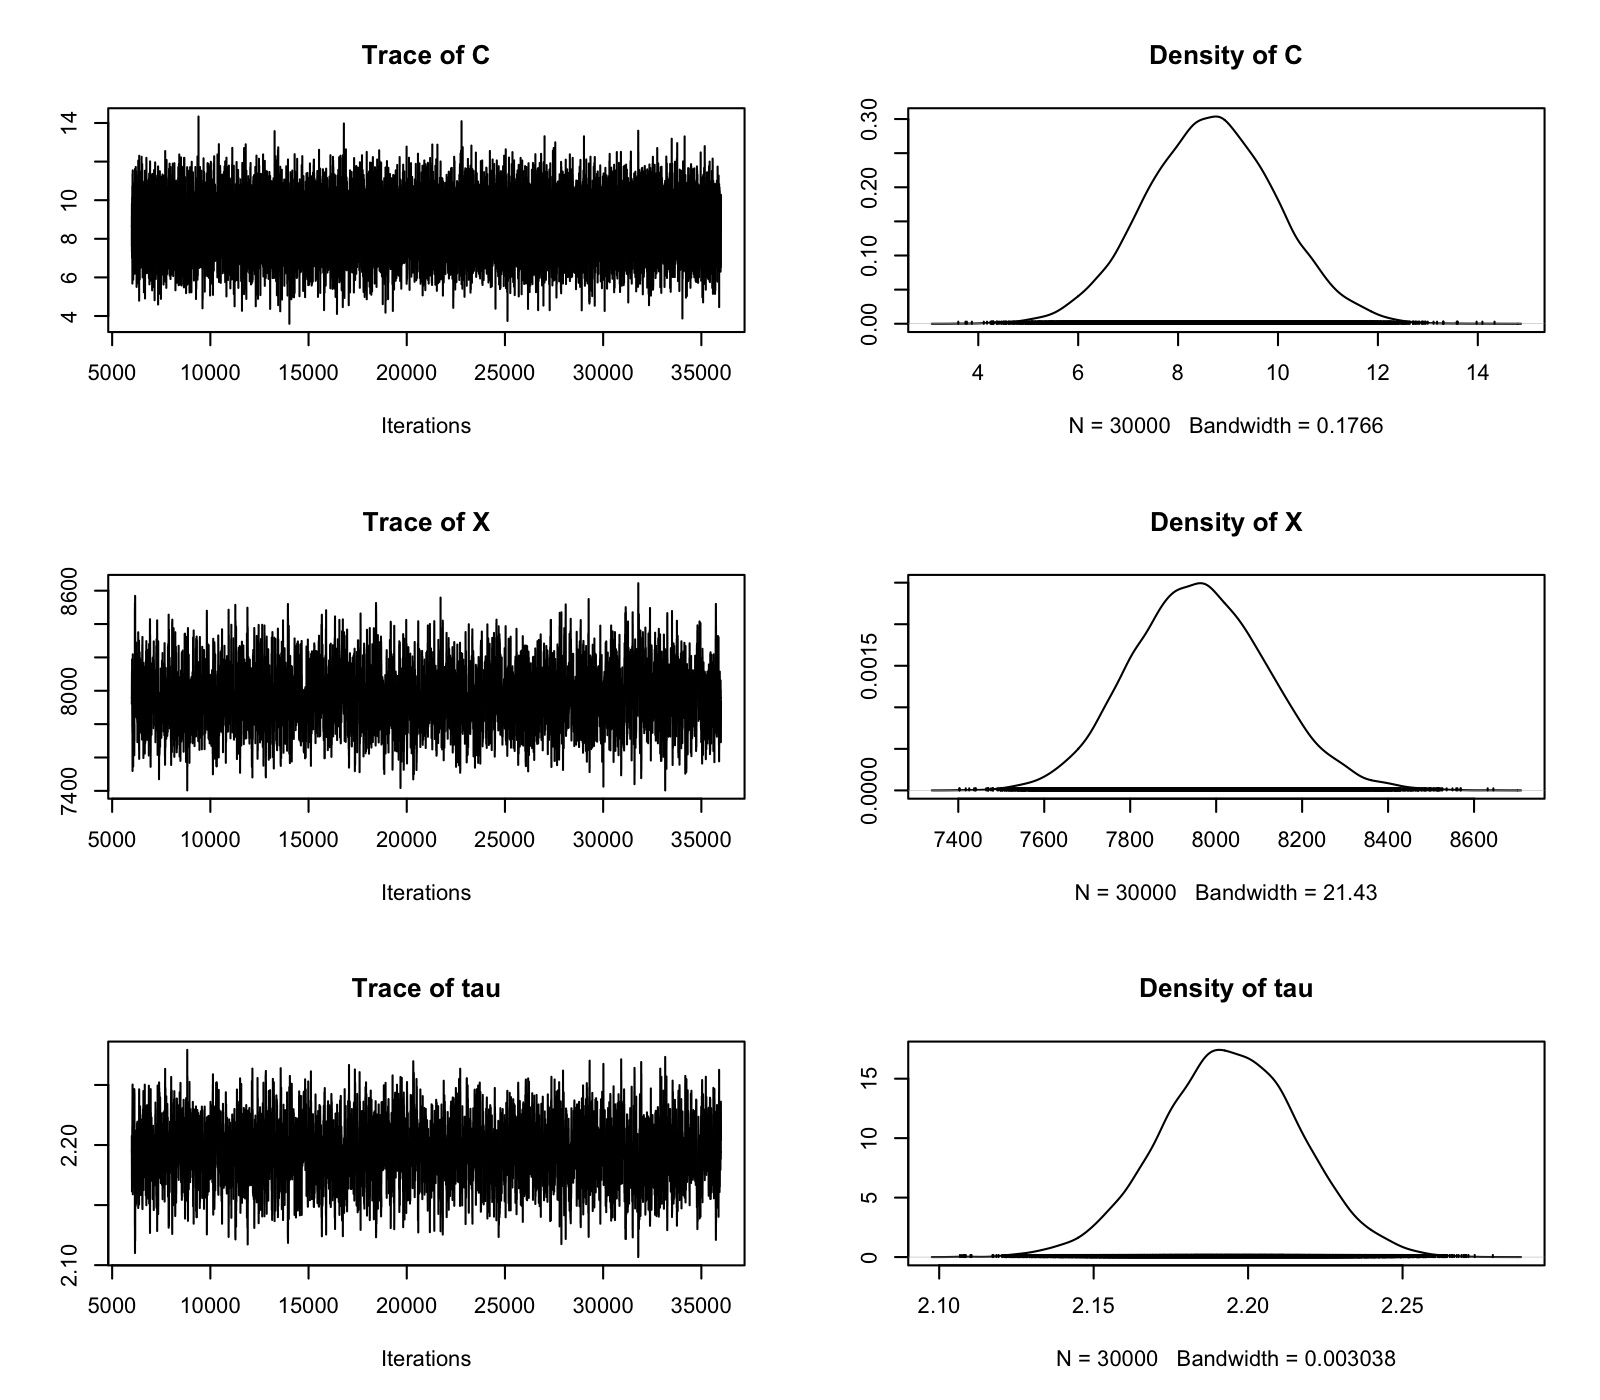

In [18]:
options(repr.plot.width=8)
options(repr.plot.height=7)

# restricting the data from 2 to 10
newdata2to10 <- preproc(r, c(2,10))
newh2to10 <- hist(newdata2to10, breaks=seq(from=2, to=10, by=0.4), plot=F)

# preparing the input for jags
jm.input <- NULL
jm.input$t <- newh2to10$mids
jm.input$Y <- newh2to10$counts
jm.input$n <- length(newh2to10$mids)

# updating the model
model.lifetime <- "
model {
 # likelihood
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau);
  lambda[i] <- X*prob[i] + C
  Y[i] ~ dpois(lambda[i]);
 }

 # priors for the parameters
 tau ~ dnorm(2,1);
 X ~ dunif(0,1e5);
 C ~ dnorm(8.705, 0.57);
}
"

# running the model
jm <- jags.model(textConnection(model.lifetime), data = jm.input)
update(jm,5000)
red2to10.chain <- coda.samples(jm, c("tau","X","C"), n.iter=30000)
summary(red2to10.chain)
red2to10.chain.df <- as.data.frame(as.mcmc(red2to10.chain))

# and printing the chain
plot(red2to10.chain)

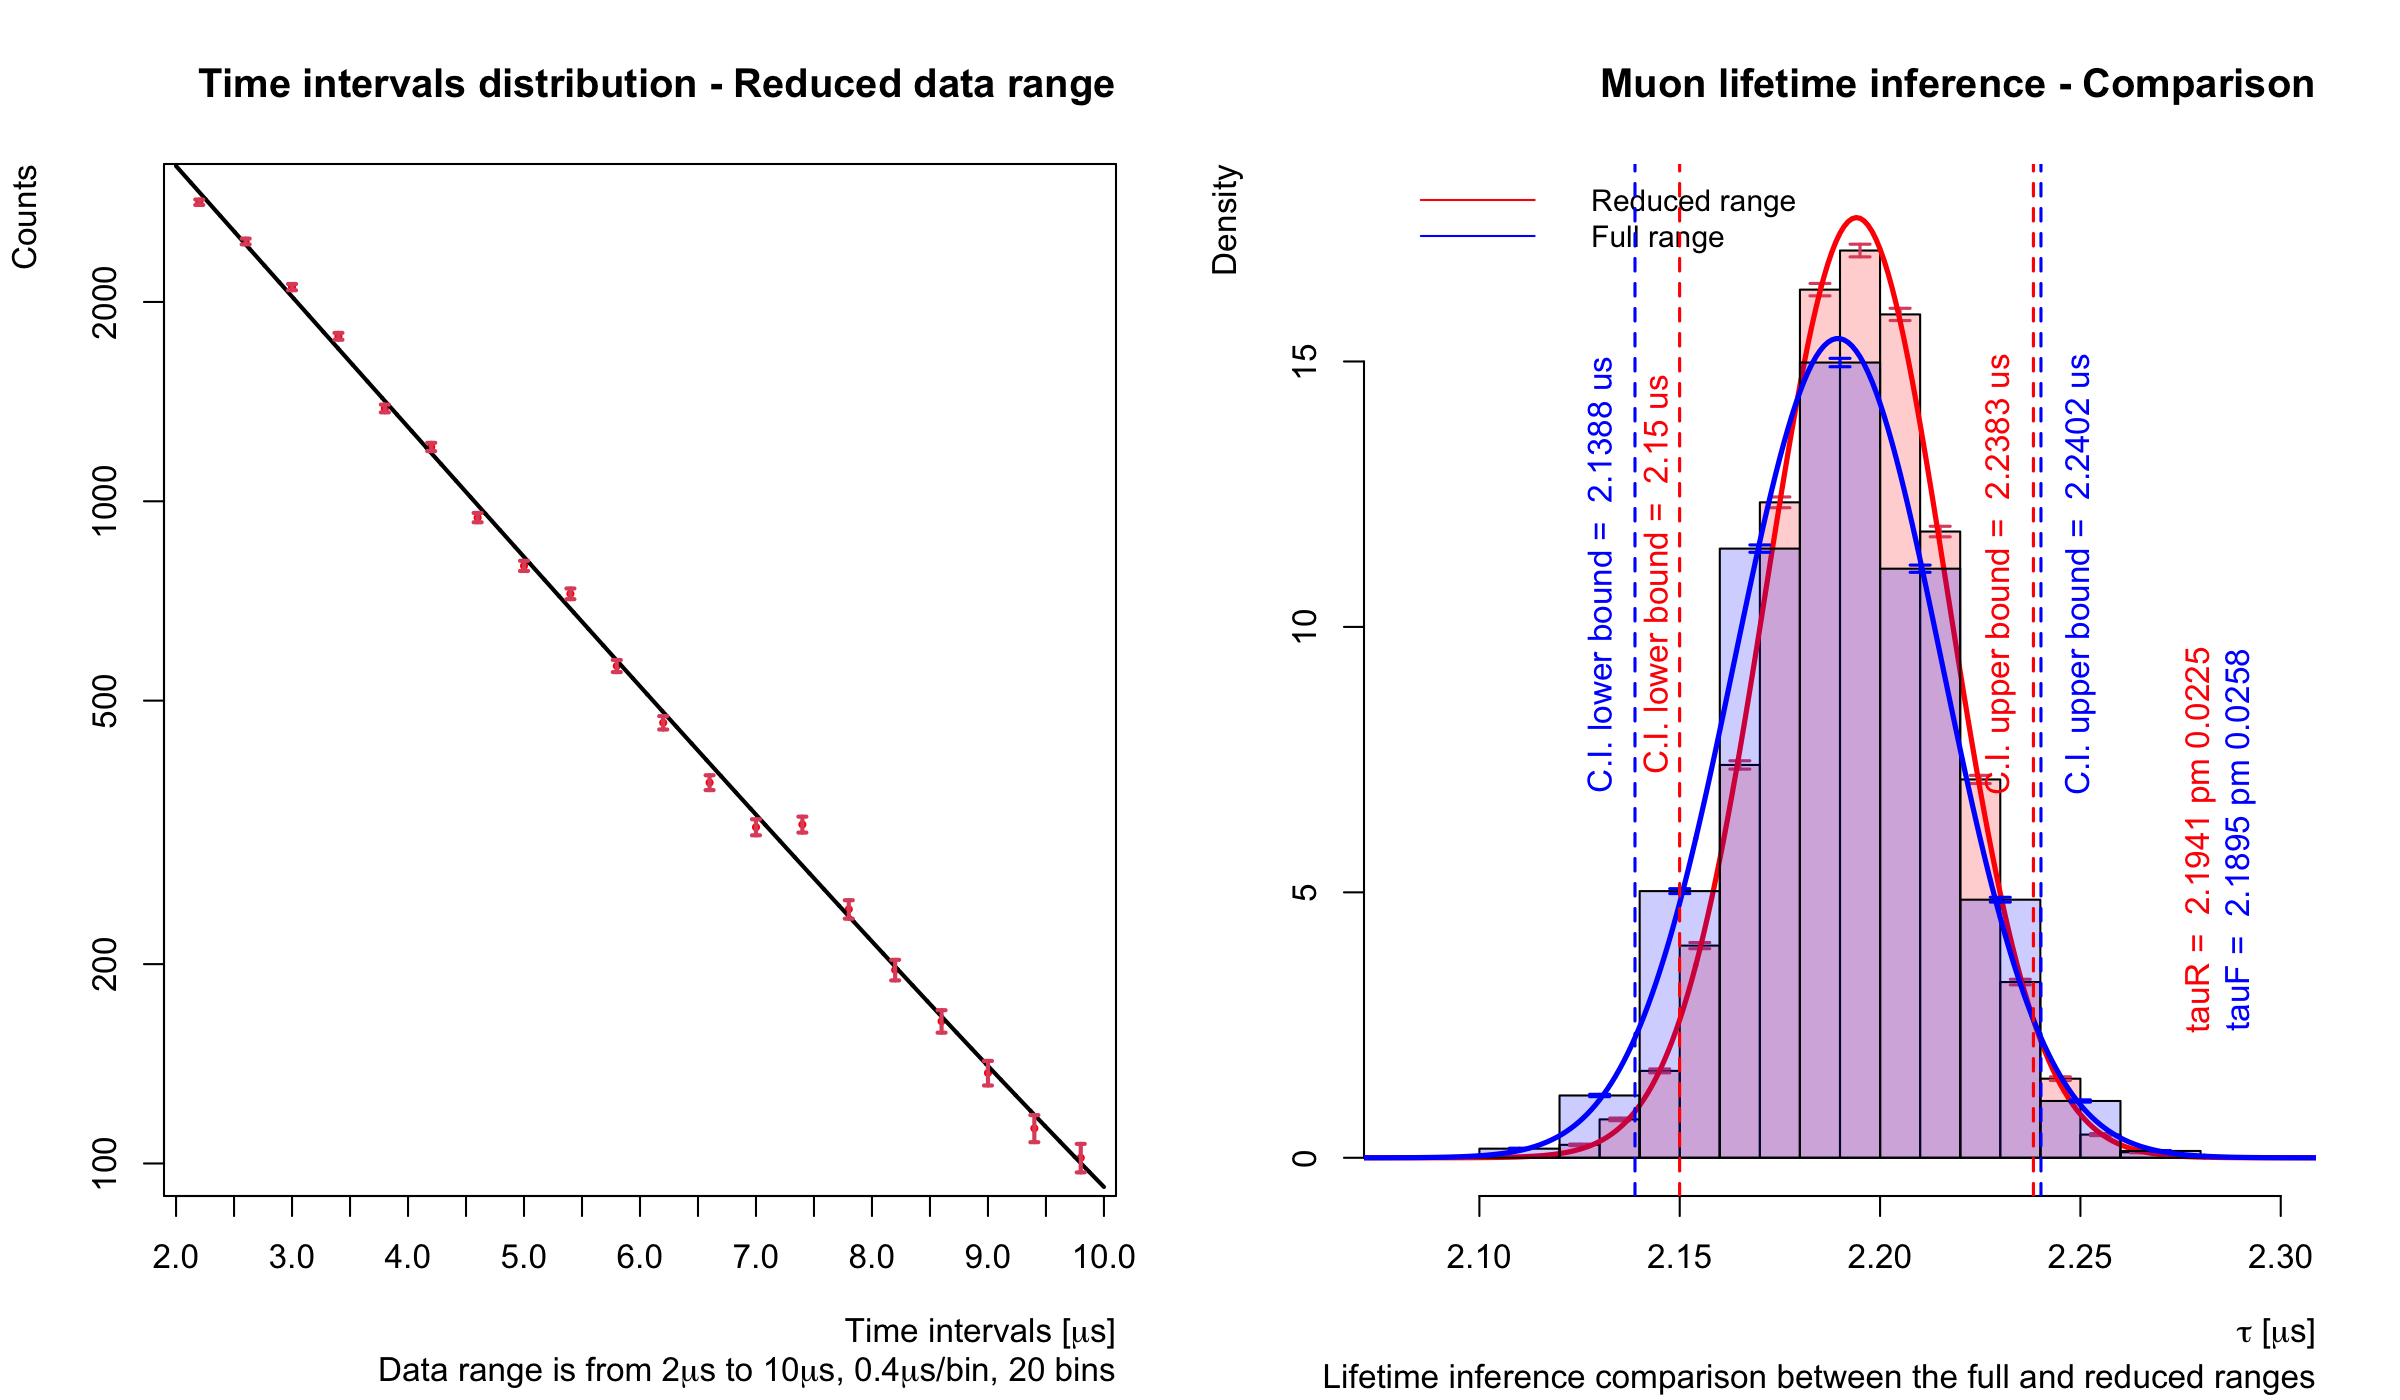

In [19]:
# showing the results
options(repr.plot.width=12)
options(repr.plot.height=7)
par(mfrow=c(1,2))
plot(newh2to10$mids, newh2to10$counts, log='y', xaxt='n', pch=19, cex=0.4, col='red',
     xlab=expression(paste("Time intervals [",mu,"s]")),
     ylab="Counts",
     main="Time intervals distribution - Reduced data range",
     sub=expression(paste("Data range is from 2",mu,"s to 10",mu,"s, 0.4",mu,"s/bin, 20 bins")),
     adj=1
)
axis(1, at = seq(2, 10, by = 0.5), las=1)
# obtaining inference
red2to10.mcT = mean(red2to10.chain.df$tau)
red2to10.mcT.sigma <- sd(red2to10.chain.df$tau)
red2to10.mcC = mean(red2to10.chain.df$C)
red2to10.mcX = mean(red2to10.chain.df$X)
# plotting
xpt <- seq(from=2, to=10, by=1/1000)
ypt <- red2to10.mcX*exp(-xpt/red2to10.mcT) + red2to10.mcC
lines(xpt, ypt, lwd=2)
errs <- sqrt(newh2to10$counts)
arrows(newh2to10$mids,newh2to10$counts+errs/2,newh2to10$mids,newh2to10$counts-errs/2,col=2,angle=90,length=0.02,code=3, lwd=2)

# plotting the inference on tau
htau2to10.red <- hist(red2to10.chain.df$tau, prob=T, main="Muon lifetime inference - Comparison", xlim=c(2.08,2.3), ylim=c(0,18),
     adj=1,
     ylab="Density",
     xlab=expression(paste(tau," [",mu,"s]")),
     sub="Lifetime inference comparison between the full and reduced ranges",
     col=rgb(1, 0, 0, alpha=0.2),
     )
# Calculate the error bars
scale_factor2to10.red <- htau2to10.red$density/htau2to10.red$counts
error2to10.red <- sqrt(htau2to10.red$counts)*scale_factor2to10.red
# Plot the error bars on the hist
min.arr.red2to10 <- htau2to10.red$density-error2to10.red/2
max.arr.red2to10 <- htau2to10.red$density+error2to10.red/2
suppressWarnings(arrows(htau2to10.red$mids,max.arr.red2to10,htau2to10.red$mids,min.arr.red2to10,col=2,angle=90,length=0.05,code=3,lwd=1.5))

x <- seq(from=1.9, to=2.5, by=1/1000)
lines(x, dnorm(x, red2to10.mcT, sd(red2to10.chain.df$tau)), lwd=2.5, col='red')
# super-imposing old
htau <- hist(full.chain.df$tau, prob=T, add=T, breaks=10, col=rgb(0, 0, 1, alpha=0.2))
lines(x, dnorm(x, full.mcT, sd(full.chain.df$tau)), lwd=2.5, col='blue')
legend("topleft", legend=c("Reduced range", "Full range"),
       col=c("red", "blue"), lty=c(1,1), cex=0.9, box.lty=0)
# Calculate the error bars
scale_factor <- htau$density/htau$counts
error <- sqrt(htau$counts)*scale_factor
# Plot the error bars on the hist
min.arr <- htau$density-error/2
max.arr <- htau$density+error/2
suppressWarnings(arrows(htau$mids,max.arr,htau$mids,min.arr,col='blue',angle=90,length=0.05,code=3,lwd=1.5))

# computing the 95% C.I. for the reduced
red2to10.ci.lower <- qnorm(0.025, red2to10.mcT, sd(red2to10.chain.df$tau))
red2to10.ci.upper <- qnorm(0.025, red2to10.mcT, sd(red2to10.chain.df$tau), lower.tail=F)
abline(v=red2to10.ci.lower, lwd=1.5, lty='dashed', col='red')
abline(v=red2to10.ci.upper, lwd=1.5, lty='dashed', col='red')
text(2.144,11,paste("C.I. lower bound = ",round(red2to10.ci.lower,4),"us"),srt=90,col='red')
text(2.23,11,paste("C.I. upper bound = ",round(red2to10.ci.upper,4),"us"),srt=90,col='red')
text(2.28,6,paste("tauR = ",round(red2to10.mcT,4),"pm",round(sd(red2to10.chain.df$tau),4)),col='red',srt=90)

# showing the 95% C.I. for the full
abline(v=full.ci.lower, lwd=1.5, lty='dashed', col='blue')
abline(v=full.ci.upper, lwd=1.5, lty='dashed', col='blue')
text(2.13,11,paste("C.I. lower bound = ",round(full.ci.lower,4),"us"),srt=90,col='blue')
text(2.25,11,paste("C.I. upper bound = ",round(full.ci.upper,4),"us"),srt=90,col='blue')
text(2.29,6,paste("tauF = ",round(full.mcT,4),"pm",round(sd(full.chain.df$tau),4)),col='blue',srt=90)


In [20]:
compat2to10 <- comp(c(red2to10.mcT, sd(red2to10.chain.df$tau)), c(2.1969811,0.0000022))
compat2to10

[1] 0.1268811

The final data is reported in the following table:

In [21]:
tau.df <- data.frame(tau=c(full.mcT, red.mcT, red2to10.mcT),
                     sigma_tau=c(full.mcT.sigma, red.mcT.sigma, red2to10.mcT.sigma),
                     bins=c(0.22,0.18,0.40),
                     compatibility=c(compat2to15,compat2to5,compat2to10)
                    )
rownames(tau.df) <- c("2to15","2to5","2to10")
tau.df

tau      sigma_tau  bins compatibility
2to15 2.189494 0.02584870 0.22 0.28963316   
2to5  2.193383 0.05238120 0.18 0.06868343   
2to10 2.194123 0.02252534 0.40 0.12688115

The restriction to only region $2$, after having determined the background $C$ via the first run, seems to yield better results in terms of mean and standard deviation and all of three estimates show good compatibility between each other. Our estimate for $\tau$ is thus:

In [22]:
sprintf("tau = %1.5f +/- %1.5f",red2to10.mcT,red2to10.mcT.sigma)

[1] "tau = 2.19412 +/- 0.02253"

#### 2.4 Comparison with a traditional least squares fit (via ROOT)


<table>
    <tr>
        <td>
            <img src="./img/noB_full.png" width=600>
        </td>
        <td>
            <img src="./img/noB_rest_2to10.png" width=600>
        </td>
    </tr>
</table>

We see that ROOT returns results that are similar to those obtained using JAGS from R. Specifically we have:
1. For the full range $2\mu s$ to $15 \mu s$: $\tau_F = (2.1930 \pm 0.0240)\hspace{0.2cm}\mu s$
2. For the restricted range $2\mu s$ to $10 \mu s$: $\tau_R = (2.1905 \pm 0.0211)\hspace{0.2cm}\mu s$

In [23]:
options(repr.plot.width=8)
options(repr.plot.height=7)

### 3. Analysis of the precession data

In [24]:
files.precession <- list.files(path = "./data_muong2/data/precession/2023_24", pattern = "*.dat$", full.names = TRUE)

In [25]:
# launching a cluster
cl <- makeCluster(detectCores()-1)
results.prec <- parLapply(cl, files.precession, extract_data_from_file) 
stopCluster(cl) 

#### 3.1 Introduction
The experiment is very similar to the previous one, with the addition of an external magnetic field. This magnetic field is known and has a value of 5,6 mT $\pm$ 2%. Muons are charged leptons with spin 1/2. If the angle between the magnetic field and the spin polarization is not zero, the muons will start to precess in the field. Then when the muon decays, the electrons or positrons are emited along the spin direction, by measuring this emmited particles distribution as a function of time, one can determine the precession frequency and from this, the magnetic moment of the muon, as they are related by the following expression:

$$  \omega = \frac{g_\mu}{2}\frac{e}{m_\mu} B   $$

For the previous case (magnetic field OFF), the number of detected muons at a time was governed by an exponential dependance. However, with an applied magnetic field we expect to obtain the following distribution [2][3]:

$$ N(t) = N e^{-t/\tau}[1 + \alpha \cos{(\omega t + \delta)}] + C $$

As we can see the exponential term is modulated by a cosine function, which reflects the precession of the muon spin in the magnetic field. $\alpha$ is the experimental assymetry (that depends on some conditions of the experiment), $\omega$ is the precession frequency, $\delta$ is the angle of initial muon polarization, and $C$ is the constant of background as before.

Following the same reasoning for the likelihood we used in the lifetime measurement, we can say that the expected value of counts in the $i-th$ bin, that is $\lambda_i$ will be given by the formula written above so that, this time:
$$
\lambda_i = N e^{-t_i/\tau}[1 + \alpha \cos{(\omega t + \delta)}] + C
$$
where $t_i$ is the center of the $i$-th bin. 

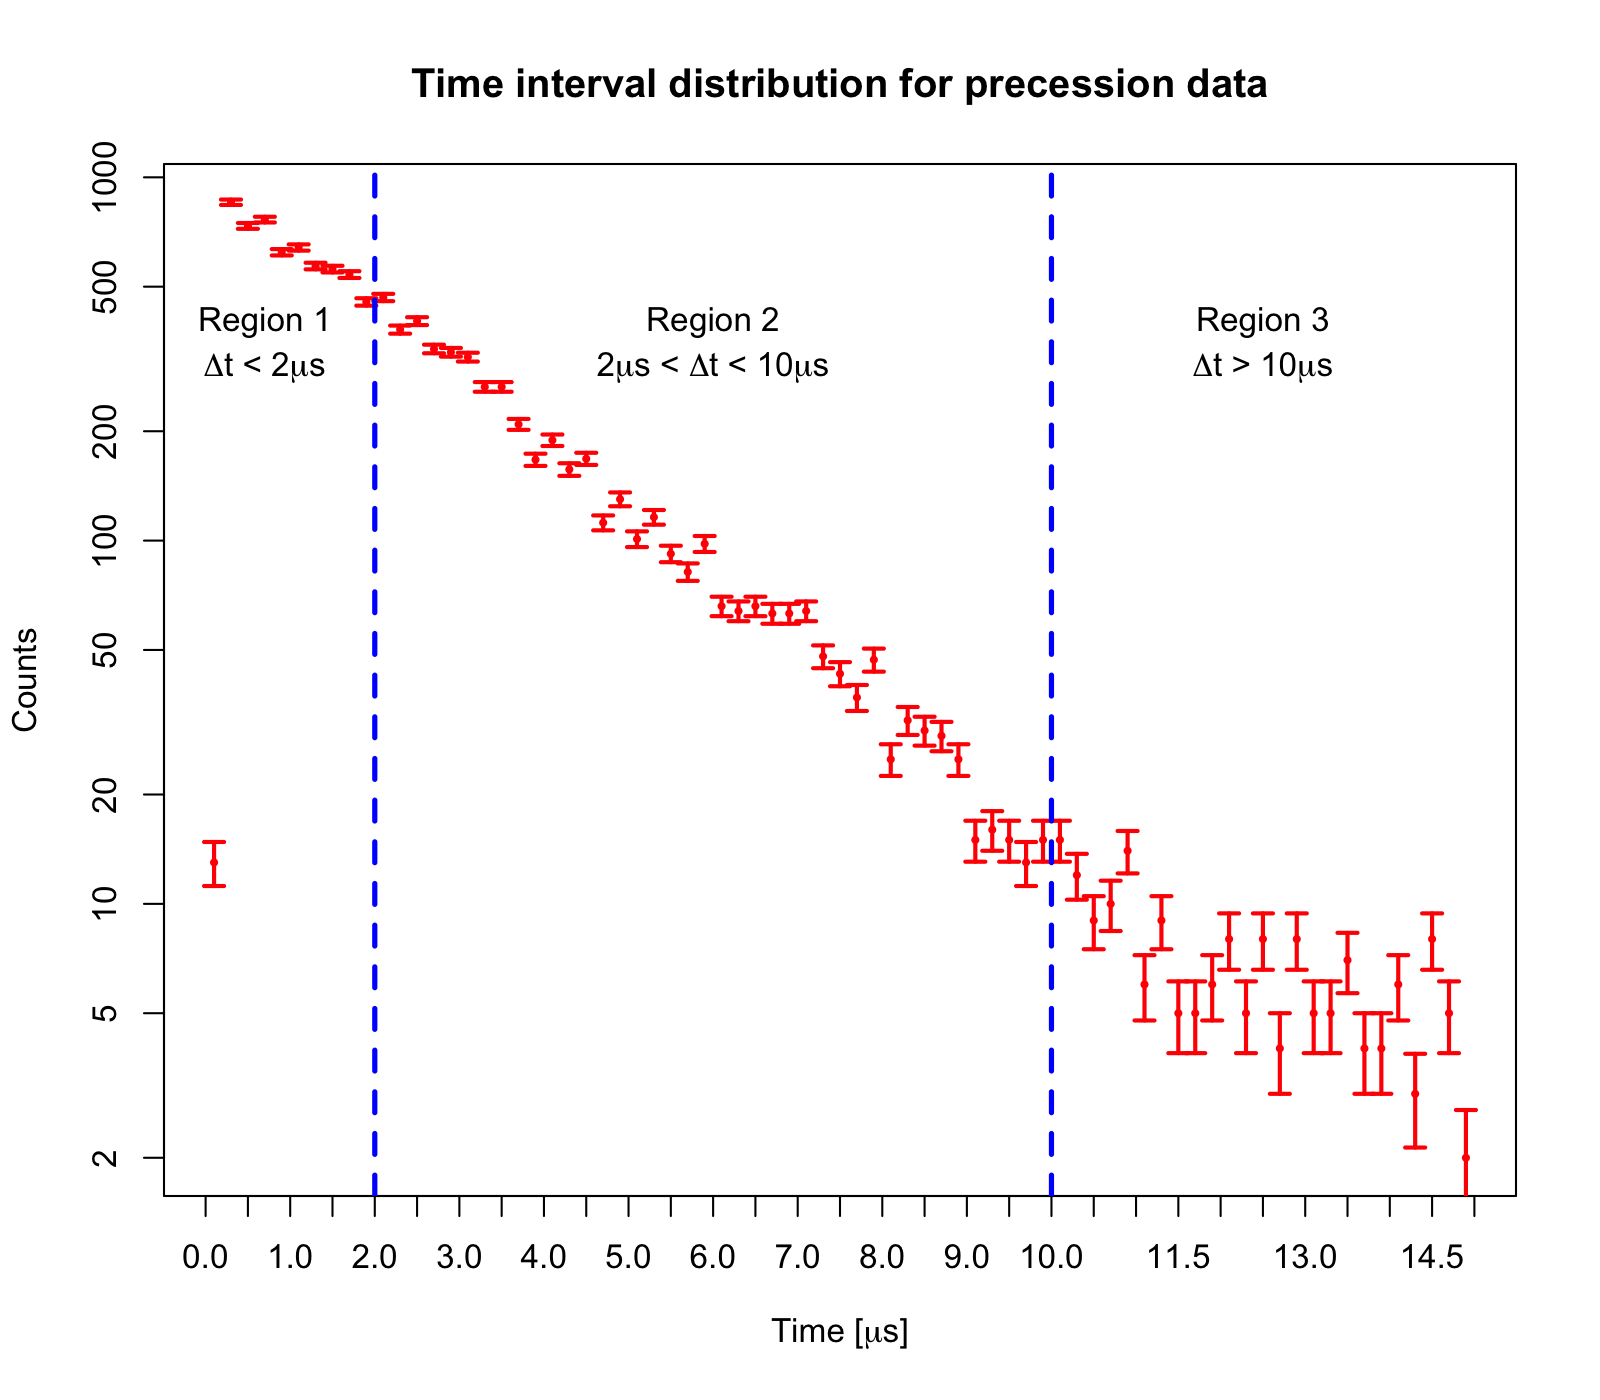

In [27]:
r.prec <- (unlist(results.prec)*14.9 + 7.4)/1000
h.prec <- hist(r.prec, breaks = 75, plot = FALSE)
plot(h.prec$mids, h.prec$counts, log='y', xaxt='n', pch=19, 
     main = "Time interval distribution for precession data",
     xlab = expression(paste("Time [",mu,"s]")), ylab = "Counts", cex=0.4, col='red')
axis(1, at = seq(0, 15, by = 0.5), las=1)
errs <- sqrt(h.prec$counts)
arrows(h.prec$mids,h.prec$counts+errs/2,h.prec$mids,h.prec$counts-errs/2,
       col='red',angle=90,length=0.05,code=3, lwd=2)

abline(v=2.,col='blue',lty='dashed',lwd=2.5)
abline(v=10,col='blue',lty='dashed',lwd=2.5)

# placing some text
text(.7, 400, "Region 1")
text(.7, 300, expression(paste(Delta,"t < 2",mu,"s")))
text(6, 400, "Region 2")
text(6,300, expression(paste("2",mu,"s < ",Delta,"t < 10",mu,"s")))
text(12.5, 400, "Region 3")
text(12.5,300, expression(paste(Delta,"t > 10",mu,"s")))

As the y axes is set to logarithmic, one would expect a linear behaviuor modulated by the cosine, and we confirm the tendency overall. However, we can observe that the first value is off the pattern so it has to be removed. Also as it was done for the lifetime measurement, data before $\approx 2 \mu s$ and after $\approx 10 \mu s$ is problematic due to the same reasoning. 

The workflow of the analysis will be the following: 

1. We will take a "general approach", in order to demostrate the importance of selecting a range on the data, considering the full range of data (except the first bin), and we will use not very restrictive priors obtaining results and comparing them with the expected values from the literature.

2. For a more "rigorous approach", we will use just the range of the data that contains more information (from 2 to 10 $\micro$s), and using the avaiable literature we will set more specific priors for the parameters in order to obtain the best results possible.

#### 3.2 Precession frequency extraction - General approach

Let's prepare the data for the jags model. We will remove the first problematic result and load the rest of the data which will be feed to the jags model. This jags model will contain broad priors of the parameters, although they have to be logical values in order to get logical results.

In [28]:
h.gen <- hist(r.prec, breaks = 74, plot = FALSE)
jm.input.gen <- NULL
jm.input.gen$t <- h.gen$mids[-1]
jm.input.gen$Y <- h.gen$counts[-1]
jm.input.gen$n <- length(jm.input.gen$t)
jm.input.gen

$t
 [1]  0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5  2.7  2.9  3.1
[16]  3.3  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9  5.1  5.3  5.5  5.7  5.9  6.1
[31]  6.3  6.5  6.7  6.9  7.1  7.3  7.5  7.7  7.9  8.1  8.3  8.5  8.7  8.9  9.1
[46]  9.3  9.5  9.7  9.9 10.1 10.3 10.5 10.7 10.9 11.1 11.3 11.5 11.7 11.9 12.1
[61] 12.3 12.5 12.7 12.9 13.1 13.3 13.5 13.7 13.9 14.1 14.3 14.5 14.7 14.9

$Y
 [1] 854 735 765 622 641 570 559 540 454 467 381 402 337 330 320 265 265 209 167
[20] 189 157 168 112 130 101 116  92  82  98  66  64  66  63  63  64  48  43  37
[39]  47  25  32  30  29  25  15  16  15  13  15  15  12   9  10  14   6   9   5
[58]   5   6   8   5   8   4   8   5   5   7   4   4   6   3   8   5   2

$n
[1] 74

In [29]:
model.general <- "
model {
 # likelihood bin per bin
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau)*(1+a*cos(w*t[i] + d));
  lambda[i] <- nmu*prob[i] + C;
  Y[i] ~ dpois(lambda[i]);
 }

 # priors for the parameters
 tau ~ dunif(1,3);
 nmu ~ dunif(0,10000);
 C ~ dunif(0,100);
 a ~ dunif(-1, 1);
 w ~ dunif(2, 8);
 d ~ dunif(-1, 1);
}
"

jm.gen <- jags.model(textConnection(model.general), data = jm.input.gen)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 74
   Unobserved stochastic nodes: 6
   Total graph size: 977

Initializing model




Iterations = 6001:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean       SD  Naive SE Time-series SE
C   1.156e+00  0.52908 0.0030546      0.0067917
a   1.904e-02  0.02161 0.0001248      0.0005056
d   2.329e-01  0.59651 0.0034440      0.0163456
nmu 1.015e+03 16.23634 0.0937405      0.2801653
tau 2.369e+00  0.03044 0.0001757      0.0005350
w   4.281e+00  1.72599 0.0099650      0.0803432

2. Quantiles for each variable:

         2.5%        25%       50%       75%     97.5%
C     0.20730  7.757e-01 1.132e+00 1.506e+00    2.2597
a    -0.02791  5.406e-03 2.107e-02 3.425e-02    0.0567
d    -0.93595 -2.427e-01 3.781e-01 7.590e-01    0.9793
nmu 984.09662  1.004e+03 1.014e+03 1.026e+03 1047.4099
tau   2.30852  2.348e+00 2.369e+00 2.390e+00    2.4268
w     2.04677  3.075e+00 3.765e+00 5.481e+00    7.6721



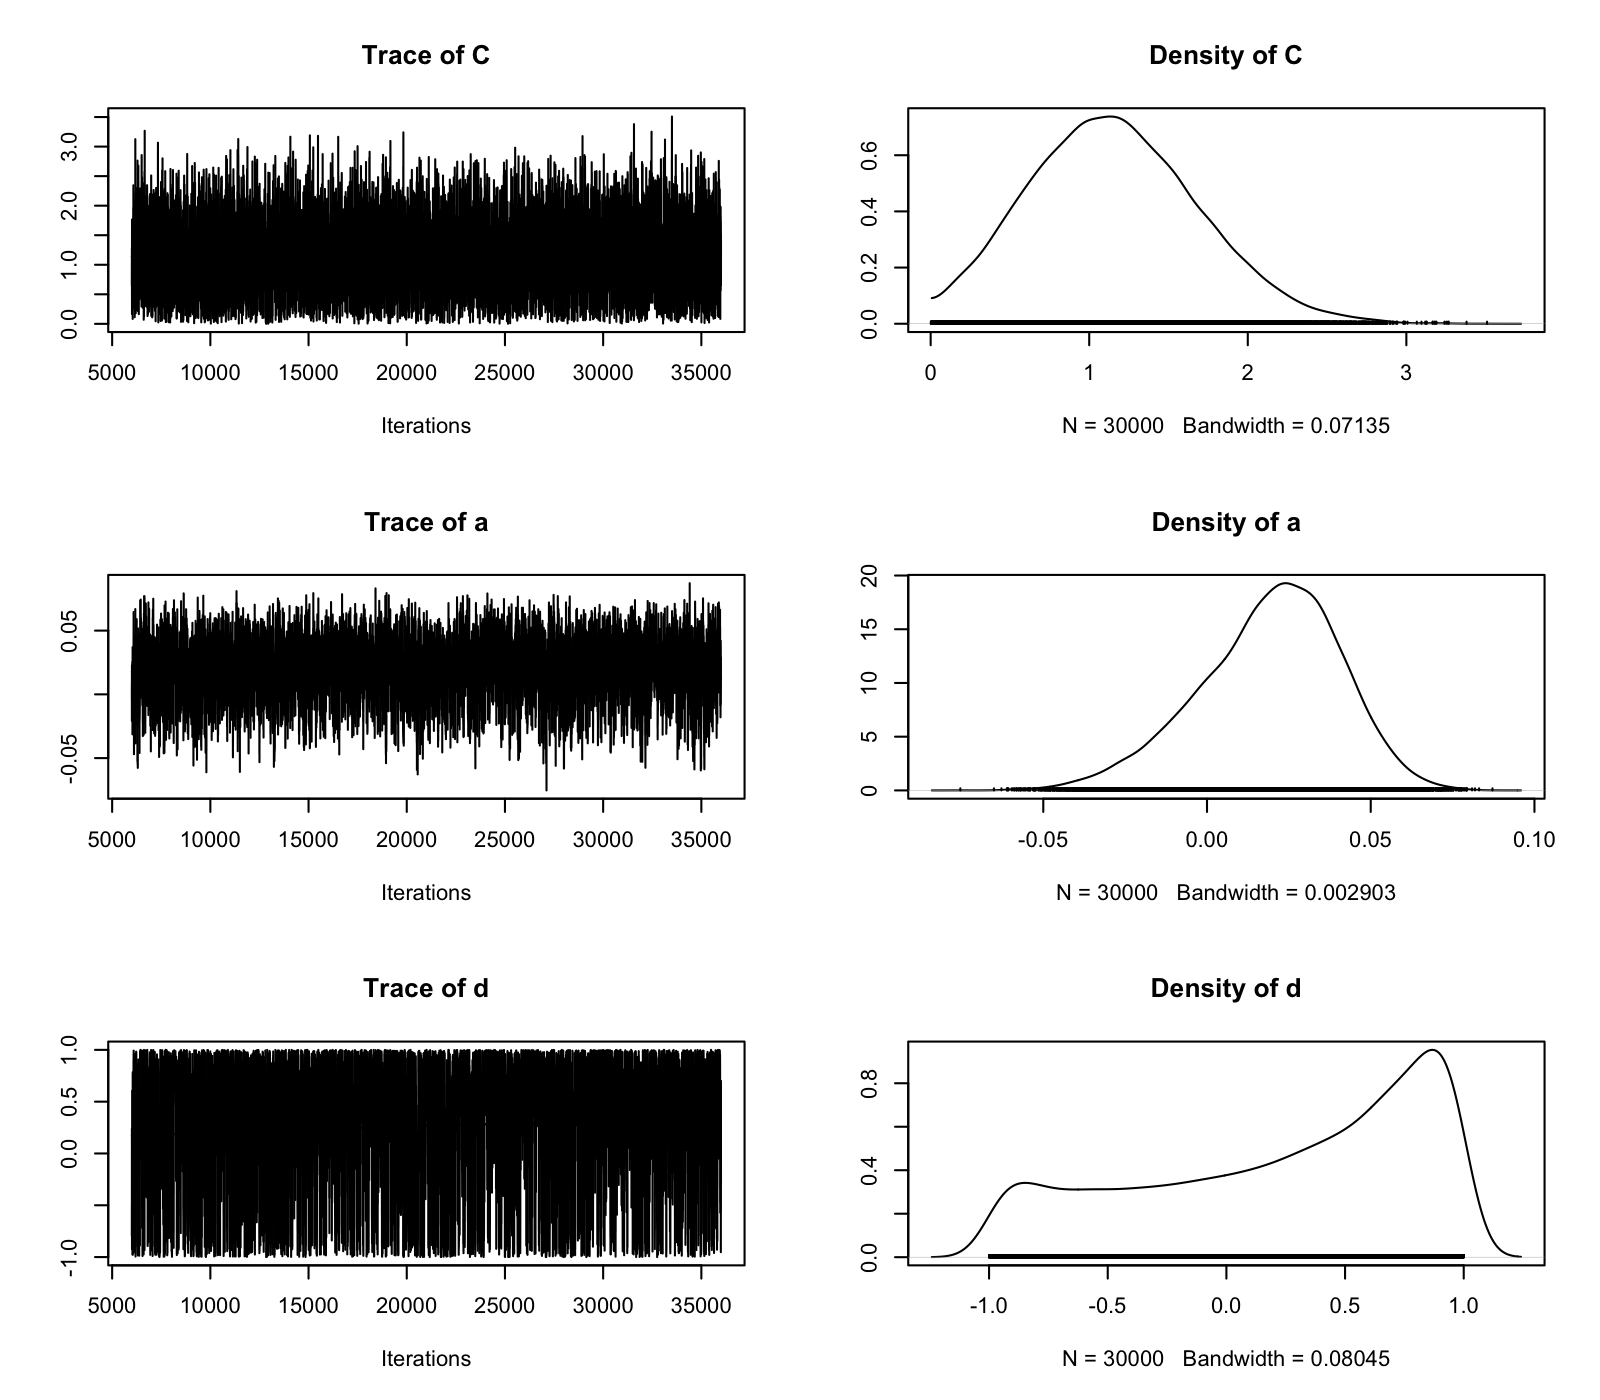

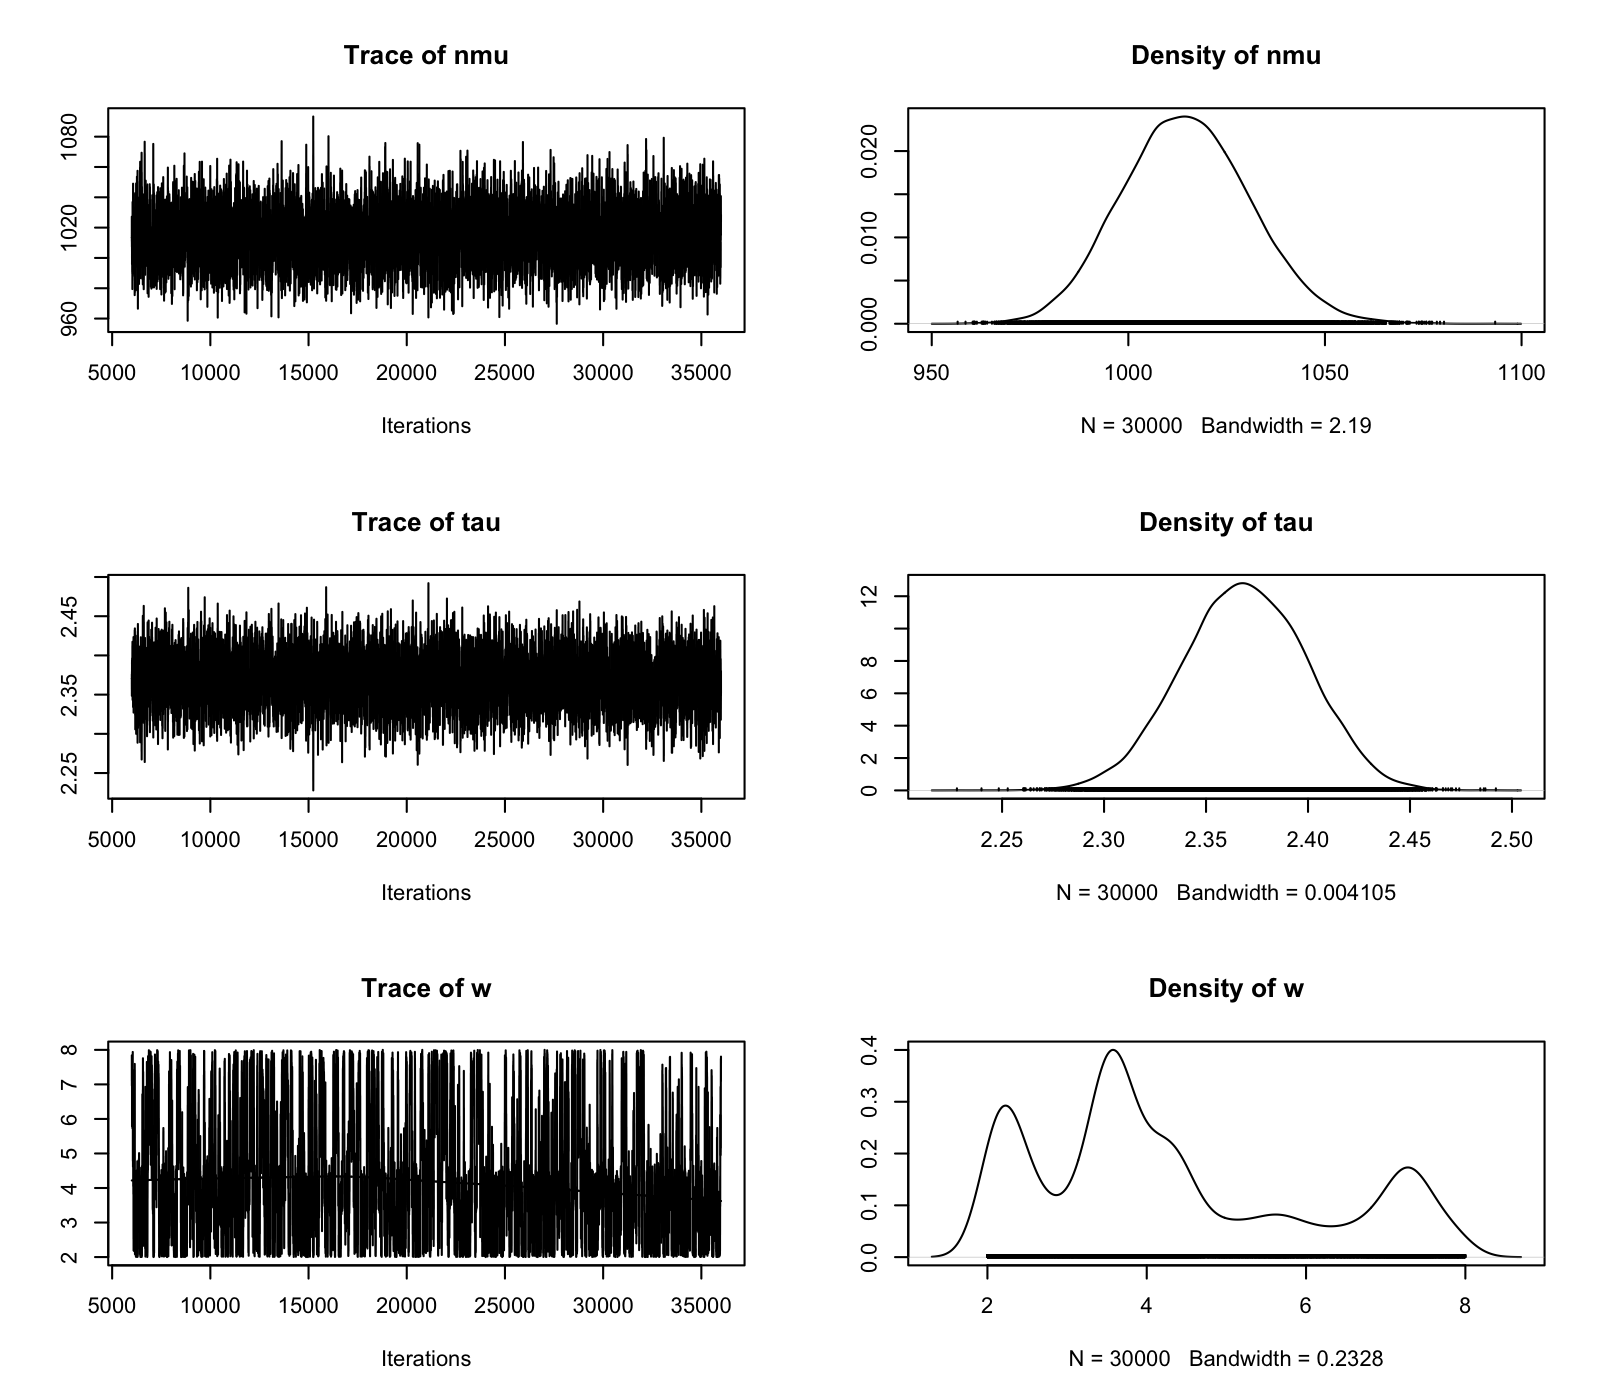

In [30]:
# training
update(jm.gen, 5000)
chain.gen <- coda.samples(jm.gen, c("w", "nmu", "tau", "a", "d", "C"), n.iter=30000)
stats.gen <- summary(chain.gen)
print(stats.gen)
# plotting a report from the chain to check
plot(chain.gen)

We can visualize how bad the results are, specially for the precession frequency $\omega$.

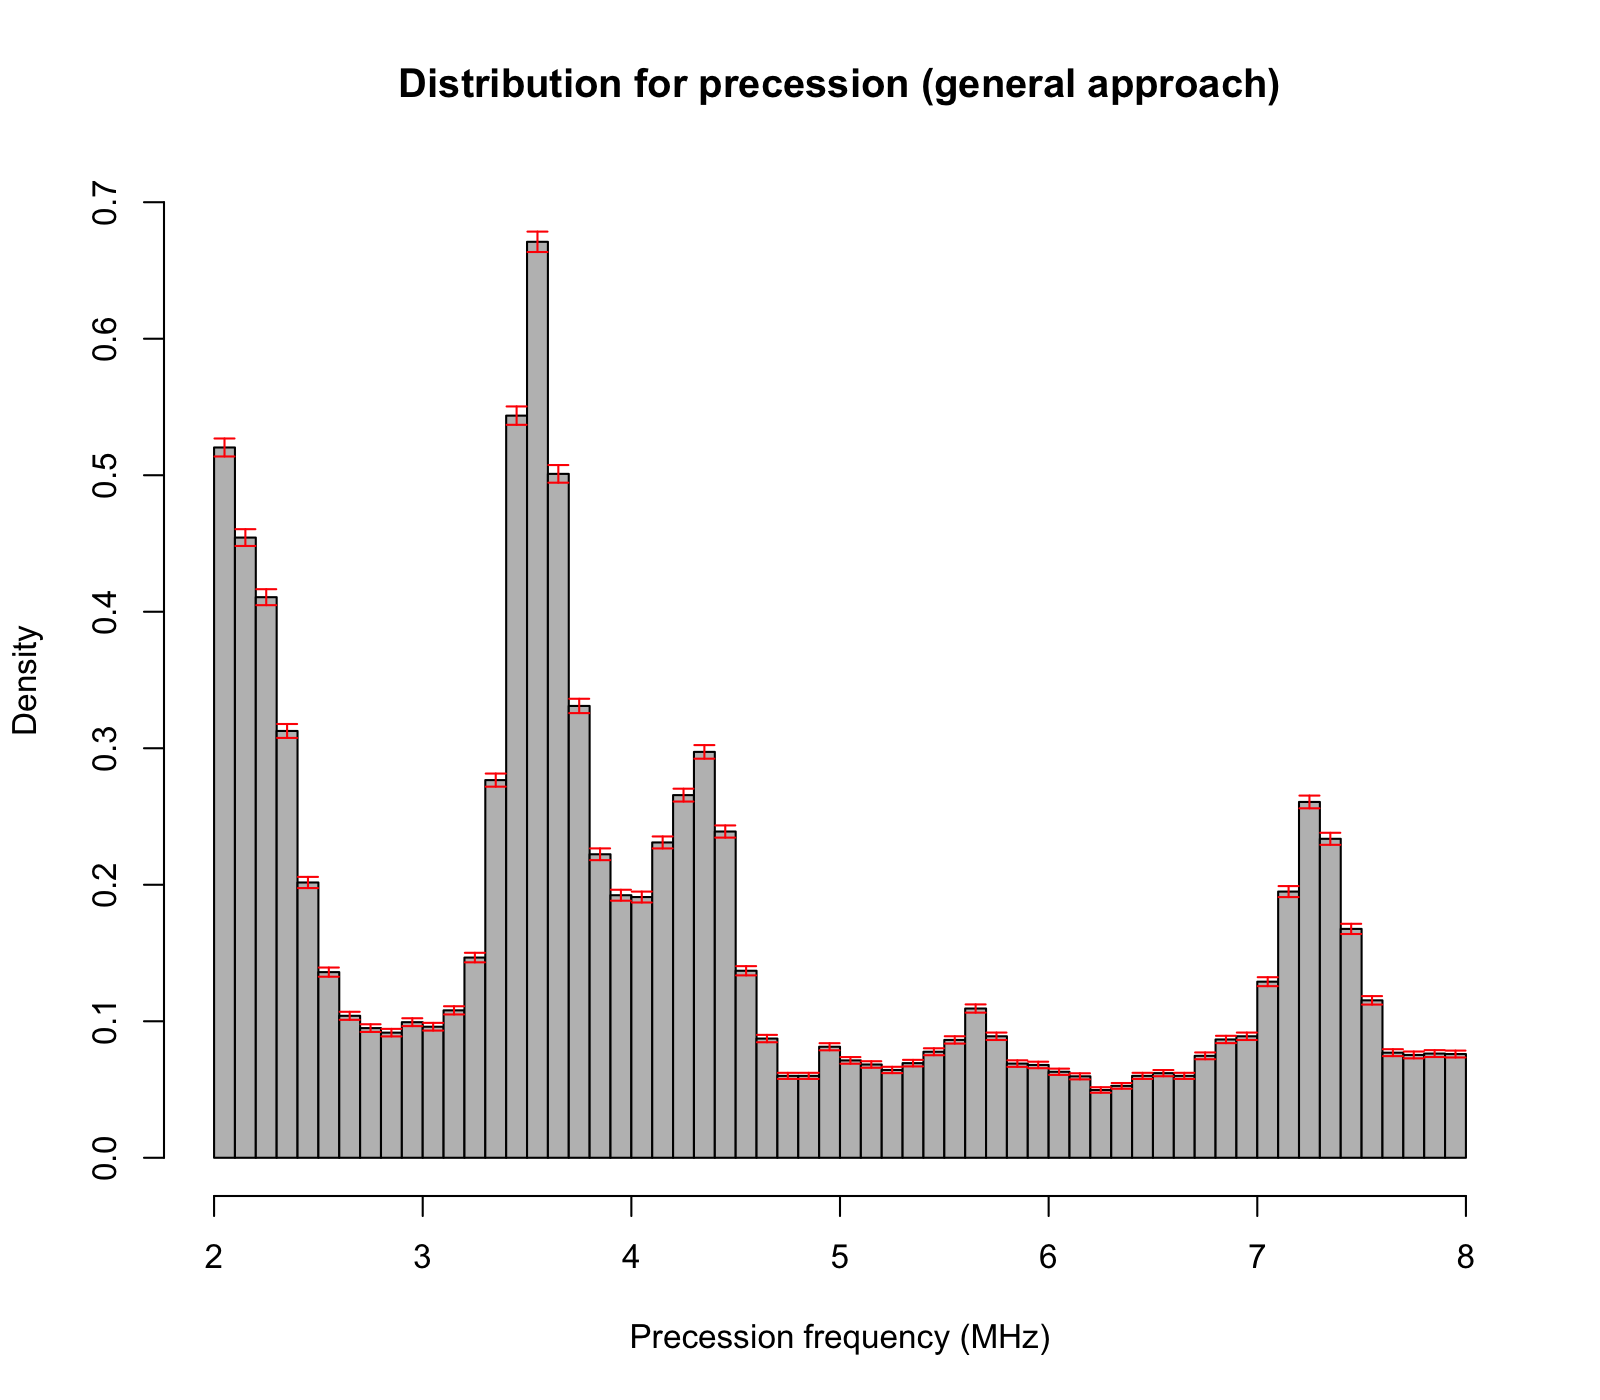

In [32]:
# conversion to dataframe
chain.df.gen <- as.data.frame(as.mcmc(chain.gen))

# Plot the histogram with adjusted ylim for error bars
h_wgen <- hist(chain.df.gen$w, breaks=50, col='grey', prob= T,
               main="Distribution for precession (general approach)", 
               xlab="Precession frequency (MHz)", ylab="Density", ylim=c(0,0.7)) 

# Calculate the error bars
scale_factor <- h_wgen$density/h_wgen$counts
error <- sqrt(h_wgen$counts)*scale_factor

# Plot the error bars
arrows(x0 = h_wgen$mids, y0 = h_wgen$density - error/2, 
       x1 = h_wgen$mids, y1 = h_wgen$density + error/2, 
       code = 3, angle = 90, length = 0.05, col = 'red')

This distribution differs significantly from the expected Gaussian distribution that may be expected. A plausible explanation for this deviation could be due to the modulation of the magnetic field, which results in a more complicated expression to fit rather than for example, when computating the lifetime. The use of broad priors will result in several values of the precession frequency (with noticeable peaks around 2, 4 and 7 MHz) leading to a sufficient good fit. That is why it's important to narrow the priors. 

We will use the mean of the parameters obtained in the jags run to fit the data points.

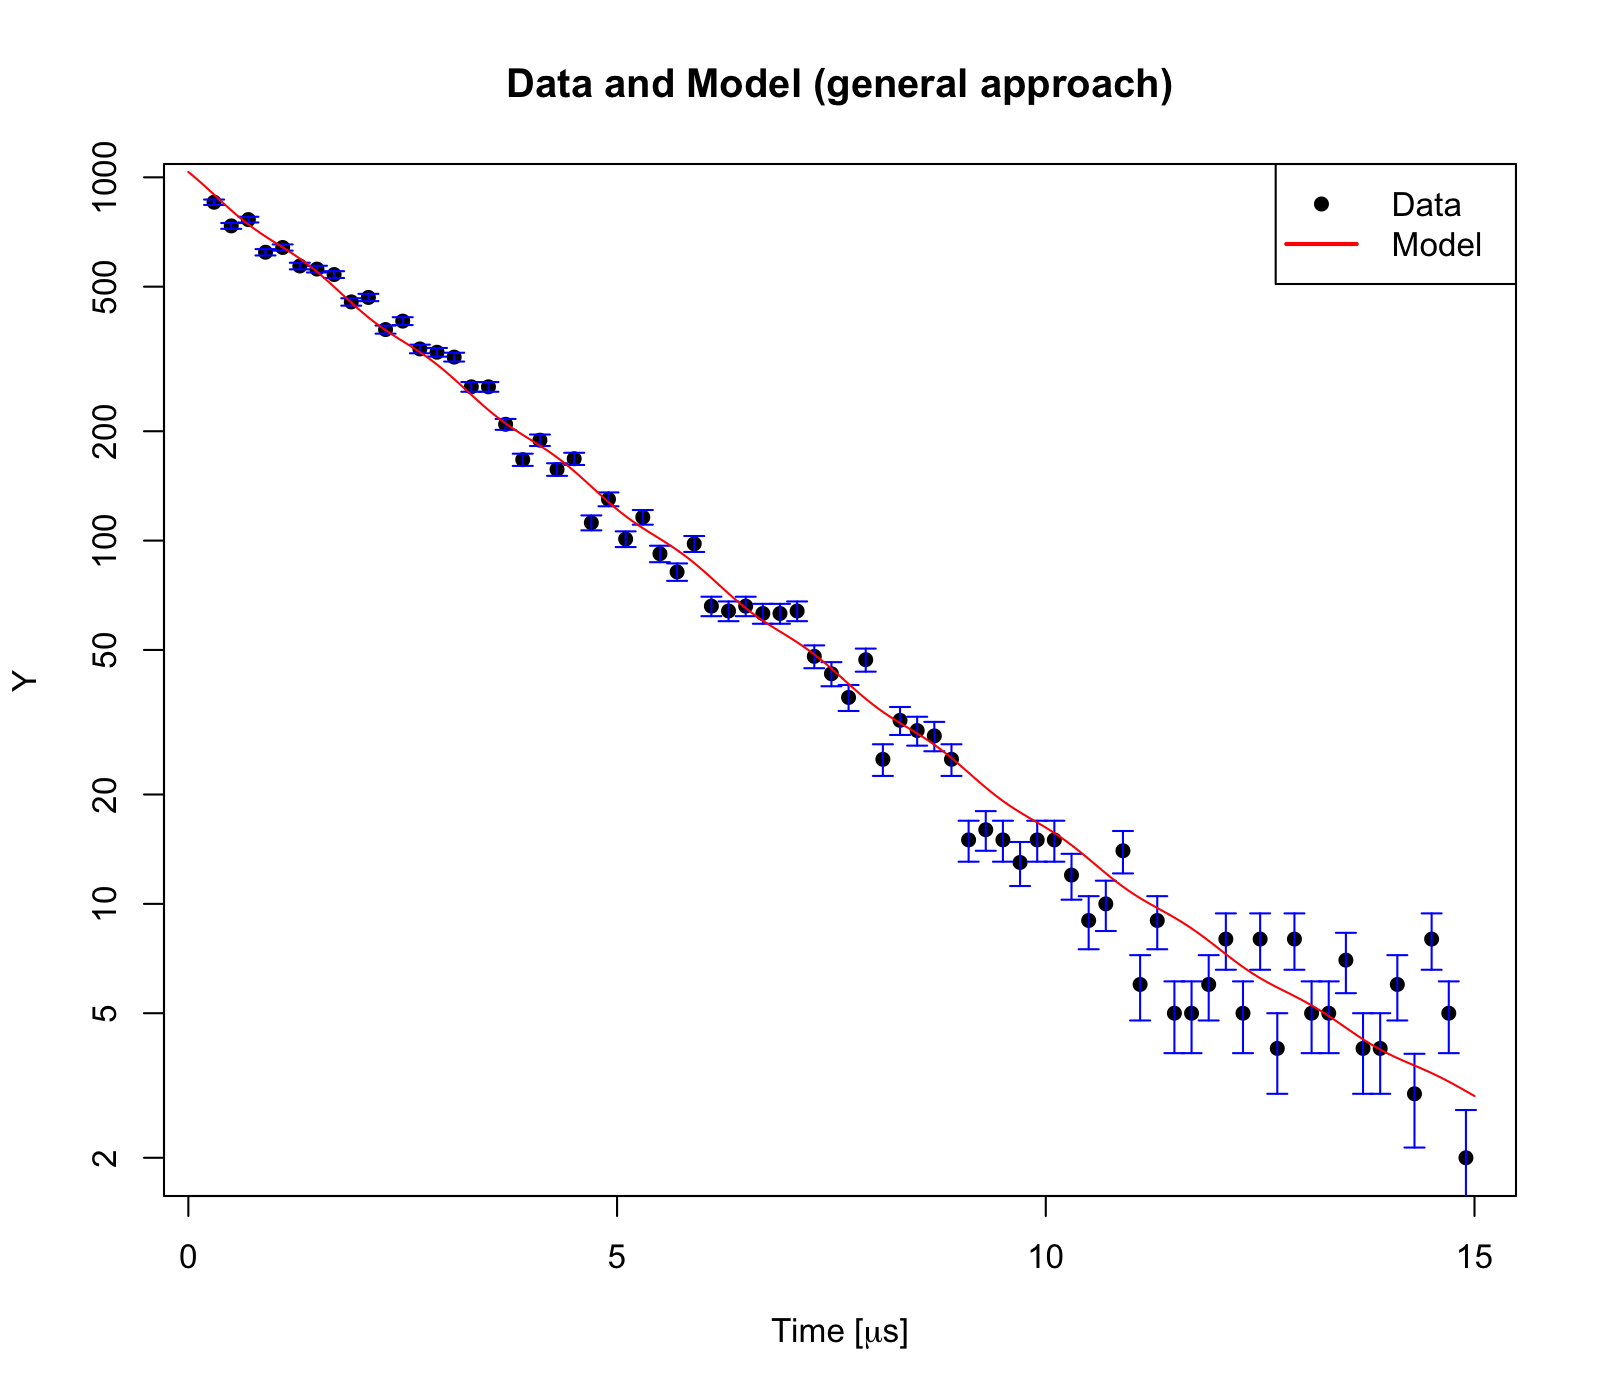

In [33]:
w <- mean(chain.df.gen$w)
nmu <- mean(chain.df.gen$nmu)
a <- mean(chain.df.gen$a)
d <- mean(chain.df.gen$d)
tau <- mean(chain.df.gen$tau)
C <- mean(chain.df.gen$C)

t <- seq(0, 15, length.out= 1000)
fit <- nmu*exp(-t/tau)*(1+a*cos(w*t+d))+C
errs <- sqrt(jm.input.gen$Y)

plot(jm.input.gen$t, jm.input.gen$Y, pch = 16, col = "black", 
     xlab = expression(paste("Time [",mu,"s]")), ylab = "Y", main = "Data and Model (general approach)",
     log = 'y')
arrows(jm.input.gen$t,jm.input.gen$Y+errs/2,jm.input.gen$t, jm.input.gen$Y-errs/2,
       col='blue',angle=90,length=0.05,code=3, lwd=1)

lines(t, fit, col = "red", lwd = 1)

legend("topright", legend = c("Data", "Model"), col = c("black", "red"), 
       pch = c(16, NA), lty = c(NA, 1), lwd = c(NA, 2))

We can see that although the fit its not bad, we don't manage to capture the oscilations procuced by the cosine modulation. This result is consistent with the bad distribution obtained for several parameters. We need a more rigorous approach.

#### 3.3 Precession frequency extraction - Rigorous approach

In order to obtain the best result possible we are going implement the following features/steps:
- We will use narrower parameters obtained from the available literature. For example, we will use the exact value of the lifetime. (2.1970... $\mu$s)
- We will perform a jags run from 2 $\micro$s to the end in order to obtain a good background constant ````C````.
- Once we have a good background parameter we will fix it and perform the jags run for the most significant range of the data: from 2 to 10 $\micro$s.

In [34]:
r.1 <- preproc(r.prec, c(2, 15))
h.1 <- hist(r.1, breaks = 65, plot = FALSE)

jm.input.1 <- NULL
jm.input.1$t <- h.1$mids
jm.input.1$Y <- h.1$counts
jm.input.1$n <- length(h.1$mids)
jm.input.1

$t
 [1]  2.1  2.3  2.5  2.7  2.9  3.1  3.3  3.5  3.7  3.9  4.1  4.3  4.5  4.7  4.9
[16]  5.1  5.3  5.5  5.7  5.9  6.1  6.3  6.5  6.7  6.9  7.1  7.3  7.5  7.7  7.9
[31]  8.1  8.3  8.5  8.7  8.9  9.1  9.3  9.5  9.7  9.9 10.1 10.3 10.5 10.7 10.9
[46] 11.1 11.3 11.5 11.7 11.9 12.1 12.3 12.5 12.7 12.9 13.1 13.3 13.5 13.7 13.9
[61] 14.1 14.3 14.5 14.7 14.9

$Y
 [1] 467 381 402 337 330 320 265 265 209 167 189 157 168 112 130 101 116  92  82
[20]  98  66  64  66  63  63  64  48  43  37  47  25  32  30  29  25  15  16  15
[39]  13  15  15  12   9  10  14   6   9   5   5   6   8   5   8   4   8   5   5
[58]   7   4   4   6   3   8   5   2

$n
[1] 65

In [35]:
model.1 <- "
model {
 # likelihood bin per bin
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau)*(1+a*cos(w*t[i] + d));
  lambda[i] <- nmu*prob[i] + C;
  Y[i] ~ dpois(lambda[i]);
    
 }

 # priors for the parameters
 tau <- 2.1970;
 nmu ~ dunif(1,5000);
 C ~ dunif(0,20);
 a ~ dnorm(0.05, 1250);
 w ~ dnorm(4.7, 20);
 d ~ dnorm(-1, 1);  
}
"
jm.1 <- jags.model(textConnection(model.1), data = jm.input.1)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 65
   Unobserved stochastic nodes: 5
   Total graph size: 860

Initializing model



In [36]:
# training
update(jm.1, 5000)
chain.1 <- coda.samples(jm.1, c("w","nmu", "tau", "a", "d", "C"), n.iter=30000)
stats.1 <- summary(chain.1)
print(stats.1)


Iterations = 6001:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean       SD  Naive SE Time-series SE
C      2.32887  0.47378 0.0027354      0.0039361
a      0.04097  0.01861 0.0001075      0.0001896
d     -1.56541  0.71919 0.0041522      0.0098054
nmu 1181.27739 17.71795 0.1022946      0.1473850
tau    2.19700  0.00000 0.0000000      0.0000000
w      4.64618  0.15390 0.0008886      0.0019335

2. Quantiles for each variable:

          2.5%        25%        50%        75%      97.5%
C    1.439e+00    2.00242    2.31564    2.63790    3.29716
a    1.251e-03    0.02953    0.04172    0.05337    0.07578
d   -2.905e+00   -2.03835   -1.59382   -1.12533   -0.05984
nmu  1.146e+03 1169.33456 1181.28641 1193.30333 1215.99616
tau  2.197e+00    2.19700    2.19700    2.19700    2.19700
w    4.350e+00    4.54500    4.64494    4.74569    4.95057



In [37]:
r.2 <- preproc(r.prec, c(2, 10))
h.2 <- hist(r.2, breaks = 40, plot = FALSE)

jm.input.2 <- NULL
jm.input.2$t <- h.2$mids
jm.input.2$Y <- h.2$counts
jm.input.2$n <- length(h.2$mids)
jm.input.2

$t
 [1] 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1 5.3 5.5 5.7
[20] 5.9 6.1 6.3 6.5 6.7 6.9 7.1 7.3 7.5 7.7 7.9 8.1 8.3 8.5 8.7 8.9 9.1 9.3 9.5
[39] 9.7 9.9

$Y
 [1] 467 381 402 337 330 320 265 265 209 167 189 157 168 112 130 101 116  92  82
[20]  98  66  64  66  63  63  64  48  43  37  47  25  32  30  29  25  15  16  15
[39]  13  15

$n
[1] 40

Let's deepen a little bit into the parameters:
- Precession frequency ($\omega$): using the Larmor expression and approximating $\frac{g_\mu}{2} \sim 1$, we obtain a value around 4,7 MHz.
- Lifetime ($\tau$): we will use the exact value which has been obtained in experiments with high precission. Its value is 2.1969811(22) $\mu$s.
- $N_\mu$: is the theoretical number of muons that we would in the initial time it is a high positive number, around 1000-2000.
- Experimental assymetry $\alpha$: from the available literature and previous tries we found out that a common value is around 0.05.
- $\delta$: its initial angle of muon polarization, we found out it has to be negative and around minus one.
- $C$: backgound noise, it was computed in the previous run, around 2,33.

Now we can define much more rigorous priors.

In [38]:
model.2 <- "
model {
 # likelihood bin per bin
 for (i in 1:n) {
  prob[i] <- exp(-1*t[i]/tau)*(1+a*cos(w*t[i] + d));
  lambda[i] <- nmu*prob[i] + C;
  Y[i] ~ dpois(lambda[i]);
    
 }

 # priors for the parameters
 tau <- 2.1970;
 nmu ~ dunif(500,5000);
 C ~ dunif(1.864,2.803);
 a ~ dnorm(0.05, 1250);
 w ~ dnorm(4.7, 20);
 d ~ dnorm(-1, 1);  
}
"
jm.2 <- jags.model(textConnection(model.2), data = jm.input.2)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40
   Unobserved stochastic nodes: 5
   Total graph size: 537

Initializing model




Iterations = 6001:36000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean       SD  Naive SE Time-series SE
C      2.32862  0.26838 0.0015495      0.0020333
a      0.04087  0.01901 0.0001098      0.0001982
d     -1.53993  0.71376 0.0041209      0.0091782
nmu 1183.10100 17.09702 0.0987097      0.1280332
tau    2.19700  0.00000 0.0000000      0.0000000
w      4.63729  0.15588 0.0009000      0.0019956

2. Quantiles for each variable:

          2.5%        25%       50%        75%      97.5%
C    1.888e+00    2.09712    2.3290    2.55632  2.777e+00
a    2.364e-04    0.02909    0.0417    0.05352  7.600e-02
d   -2.847e+00   -2.01013   -1.5750   -1.10967 -9.096e-03
nmu  1.150e+03 1171.41317 1183.1649 1194.70316  1.216e+03
tau  2.197e+00    2.19700    2.1970    2.19700  2.197e+00
w    4.338e+00    4.53616    4.6337    4.73338  4.962e+00



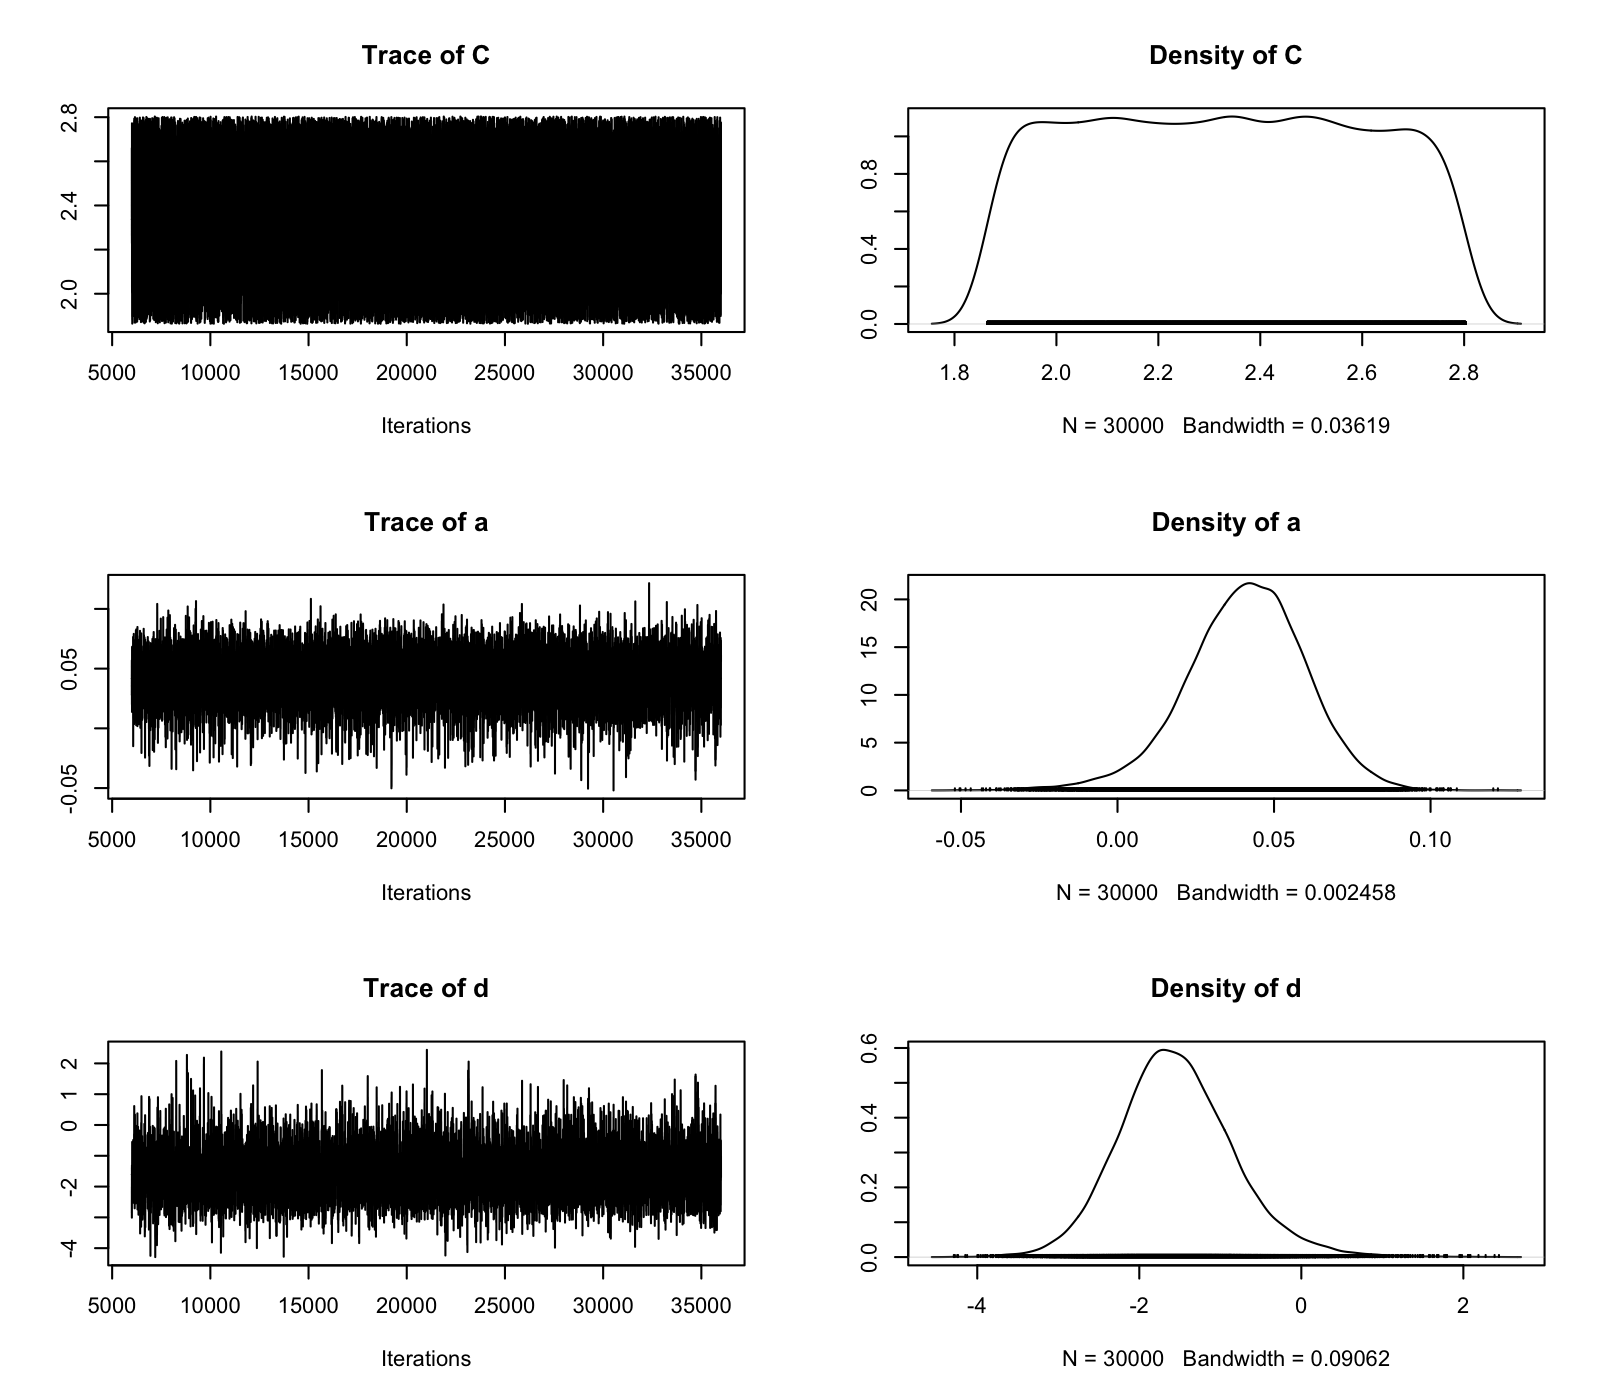

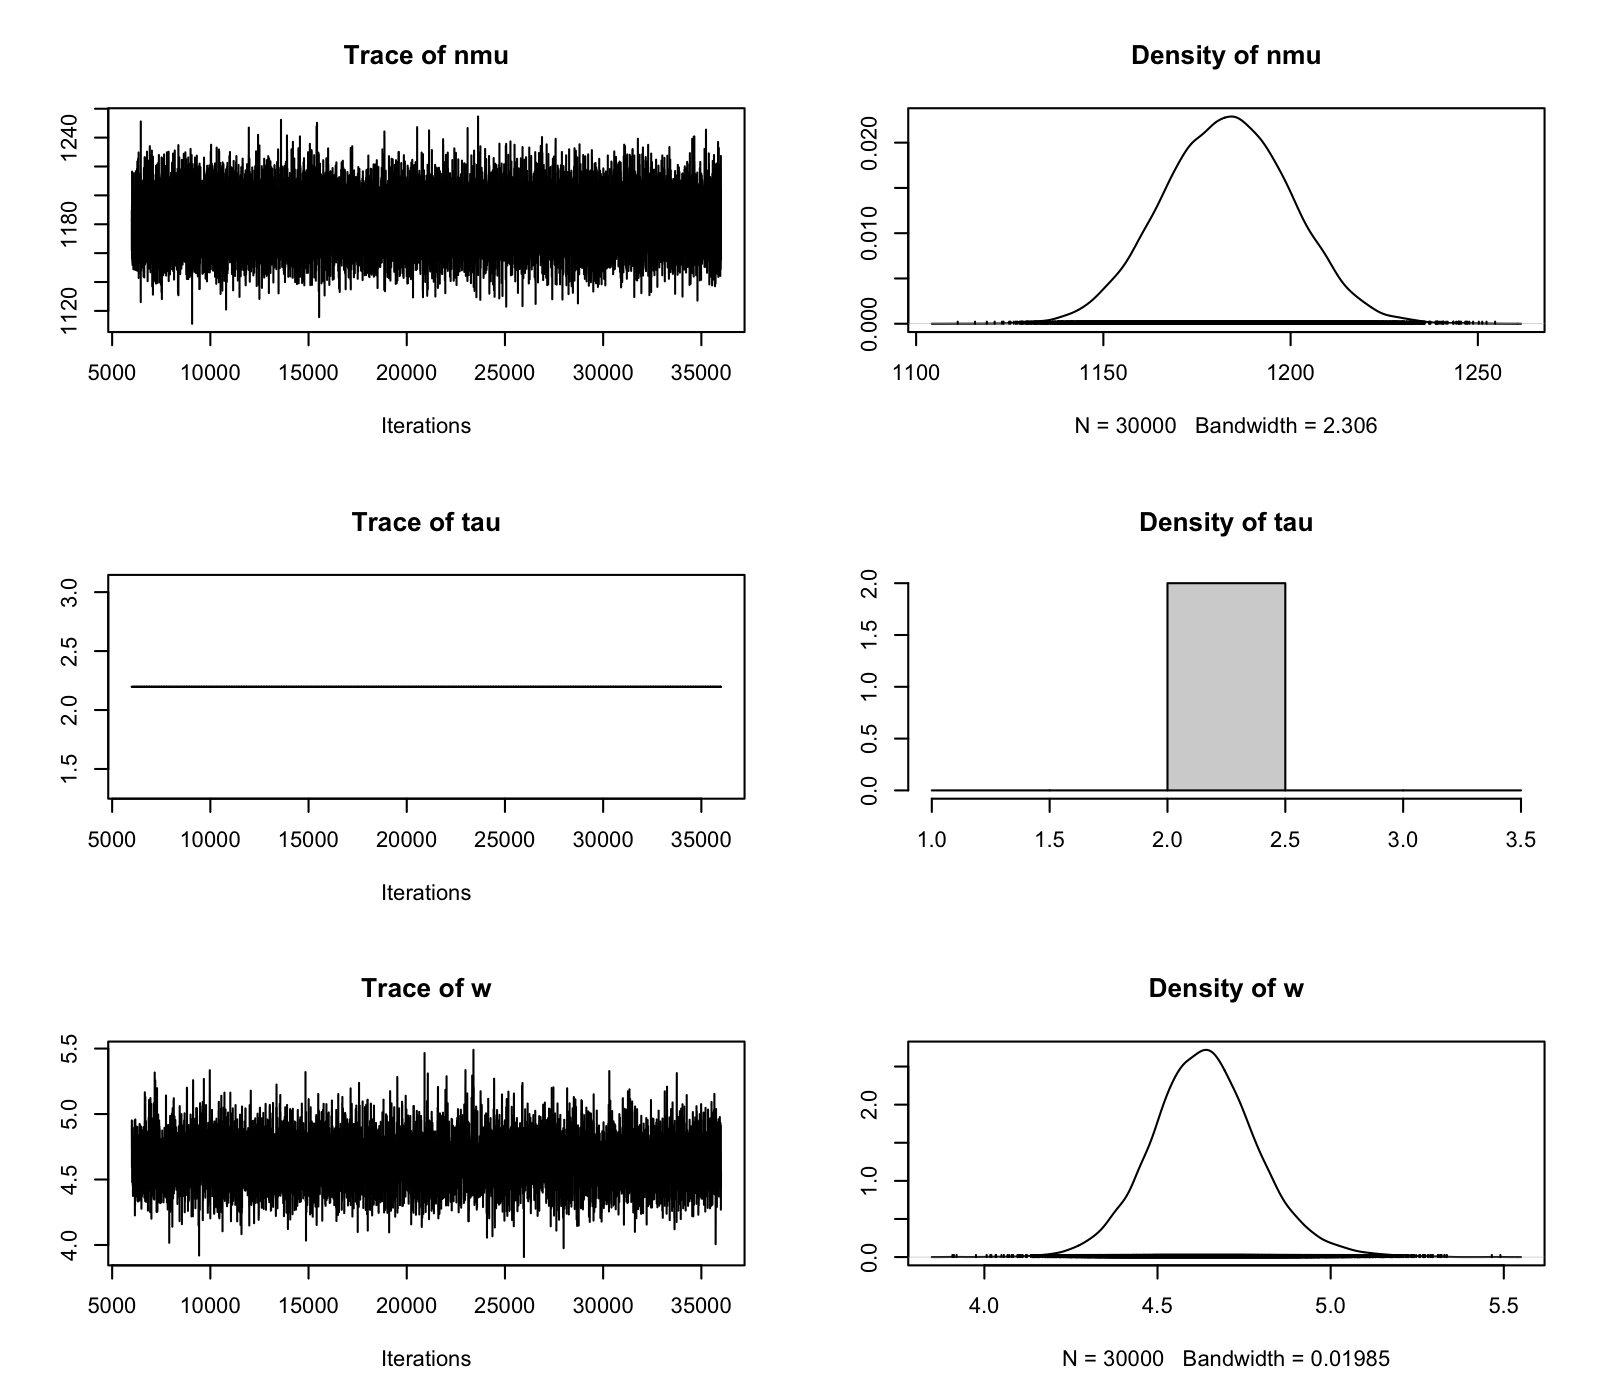

In [39]:
# training
update(jm.2, 5000)
chain.2 <- coda.samples(jm.2, c("w","nmu", "a", "d","tau", "C"), n.iter=30000)
stats.2 <- summary(chain.2)
print(stats.2)
plot(chain.2)

Except for parameter C, which appears to follow a uniform distribution, probably due to its narrow range, all other parameters exhibit distributions that are reasonably close to Gaussian. Furthermore the parameters don't deviate from their expected values. This indicates that our more rigorous approach is having a better performance, and we can expect improved results moving forward.

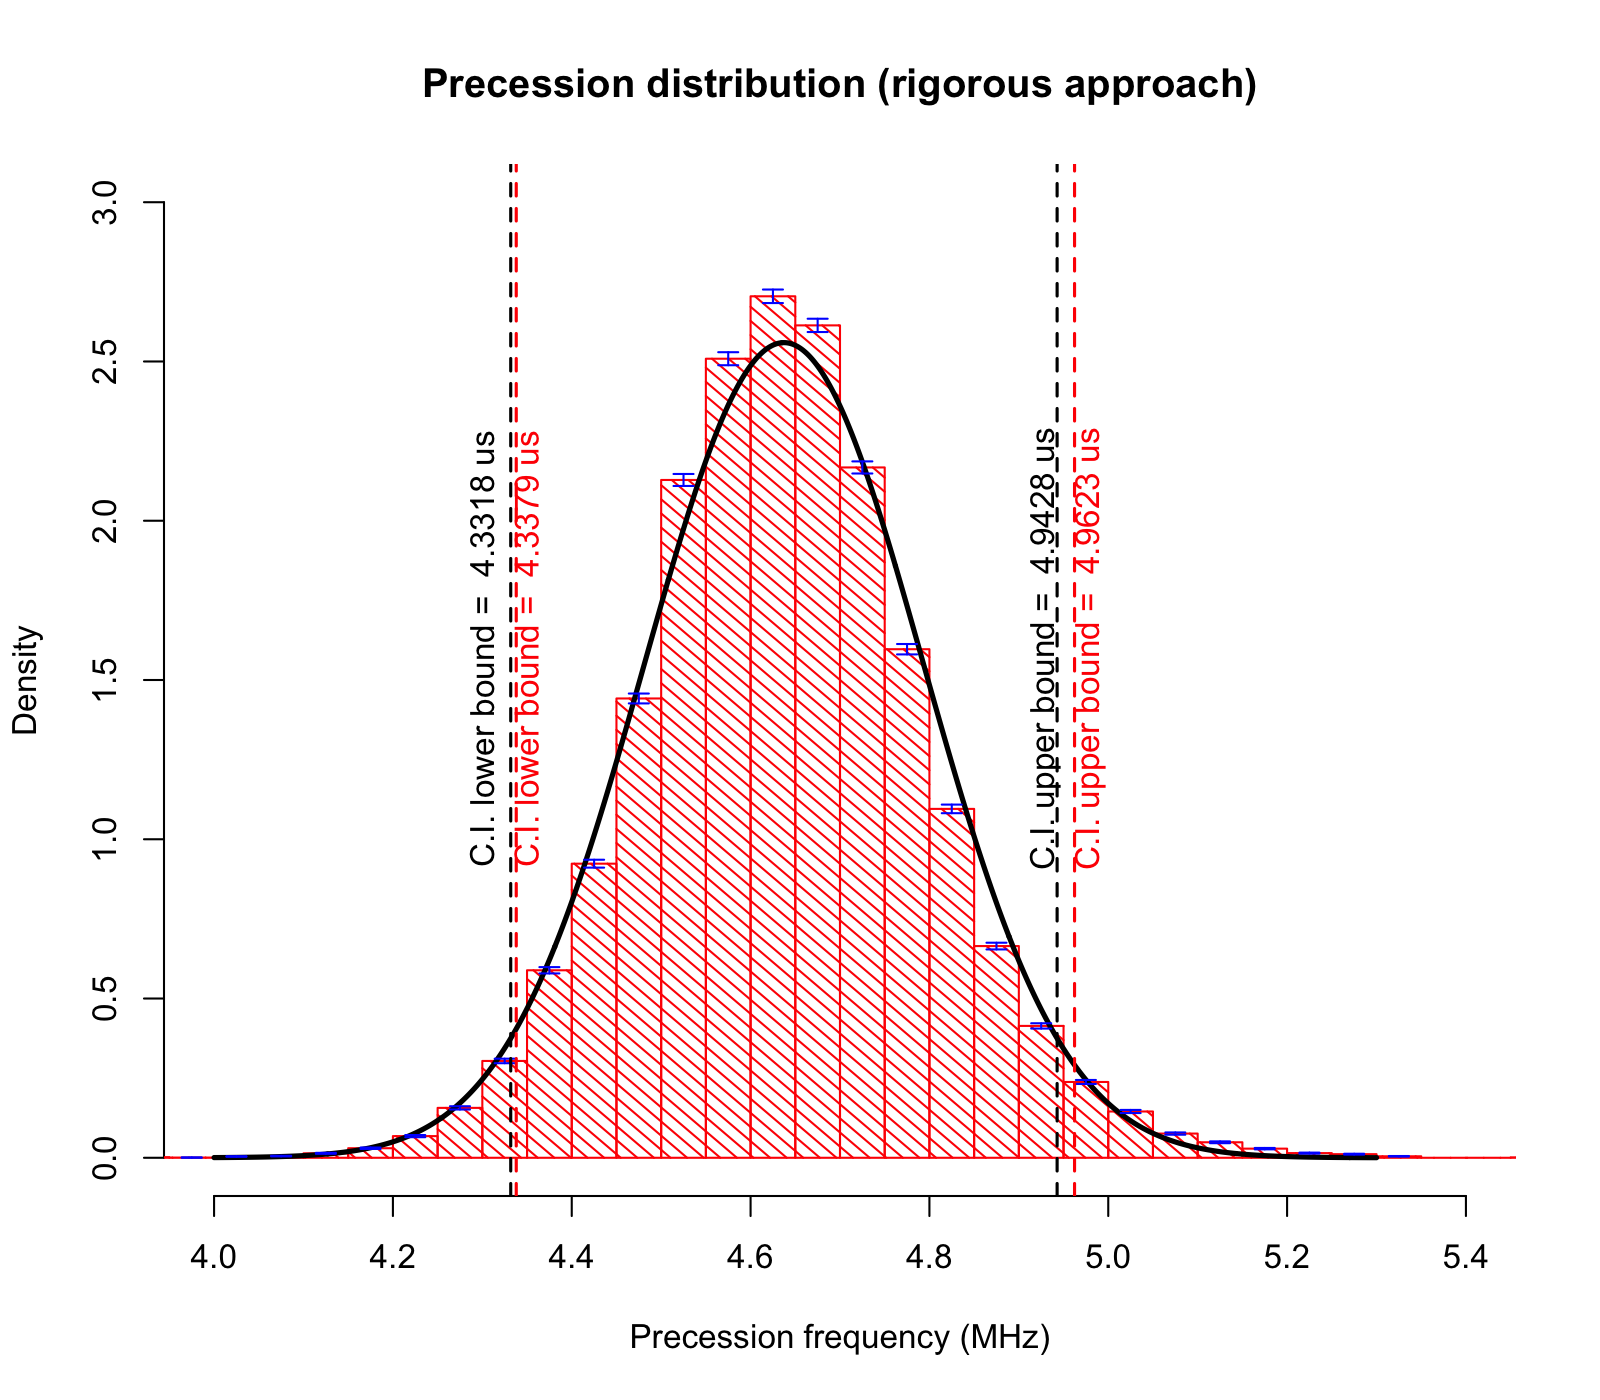

In [40]:
chain.df.2 <- as.data.frame(as.mcmc(chain.2))
h2 <- hist(chain.df.2$w, xlim=c(4.0,5.4), prob=T, breaks=30, density=20, angle=-45, col='red', 
            main = "Precession distribution (rigorous approach)", 
            xlab = "Precession frequency (MHz)",  ylim = c(0,3))

scale_factor <- h2$density/h2$counts
errs <- sqrt(h2$counts) * scale_factor

xs <- seq(from=4, to=5.3, by=1/1000.)
lines(xs, dnorm(xs, mean(chain.df.2$w), sd(chain.df.2$w)), lwd=2.5)

arrows(h2$mids,h2$density+errs/2,h2$mids,h2$density-errs/2,
       col='blue', angle = 90, length=0.05,code=3, lwd=1)

wnorm.ci.lower <- qnorm(0.025, mean(chain.df.2$w), sd(chain.df.2$w))
wnorm.ci.upper <- qnorm(0.025, mean(chain.df.2$w), sd(chain.df.2$w), lower.tail=F)

w.ci.lower <- stats.2$quantiles["w", "2.5%"]
w.ci.upper <- stats.2$quantiles["w", "97.5%"]

abline(v=wnorm.ci.lower, lwd=1.5, lty='dashed', col='black')
abline(v=wnorm.ci.upper, lwd=1.5, lty='dashed', col='black')
text(4.3,1.6,paste("C.I. lower bound = ",round(wnorm.ci.lower,4),"us"),srt=90,col='black')
text(4.93,1.6,paste("C.I. upper bound = ",round(wnorm.ci.upper,4),"us"),srt=90,col='black')

abline(v=w.ci.lower, lwd=1.5, lty='dashed', col='red')
abline(v=w.ci.upper, lwd=1.5, lty='dashed', col='red')
text(4.35,1.6,paste("C.I. lower bound = ",round(w.ci.lower,4),"us"),srt=90, col="red")
text(4.98,1.6,paste("C.I. upper bound = ",round(w.ci.upper,4),"us"),srt=90, col="red")

We can observe the obtained distribution represented with the red histogram, and the black line is a Gaussian distribution with the same mean and deviation. Our intention is to visualize the resemblance between our distribution and a Gaussian. By plotting the errorbar we can see that most of the bins are compatible with the Gaussian line. We have also set confidence intervals of 95 % for both the distribution and Gaussian, we can see that the bounds are significantly close, another symptom of a good fit. The Gaussian tendency of the obtained distribution is a voucher for the good performance of the model.

Let's perform again the comparation of the data and the fit obtained from the jags run.

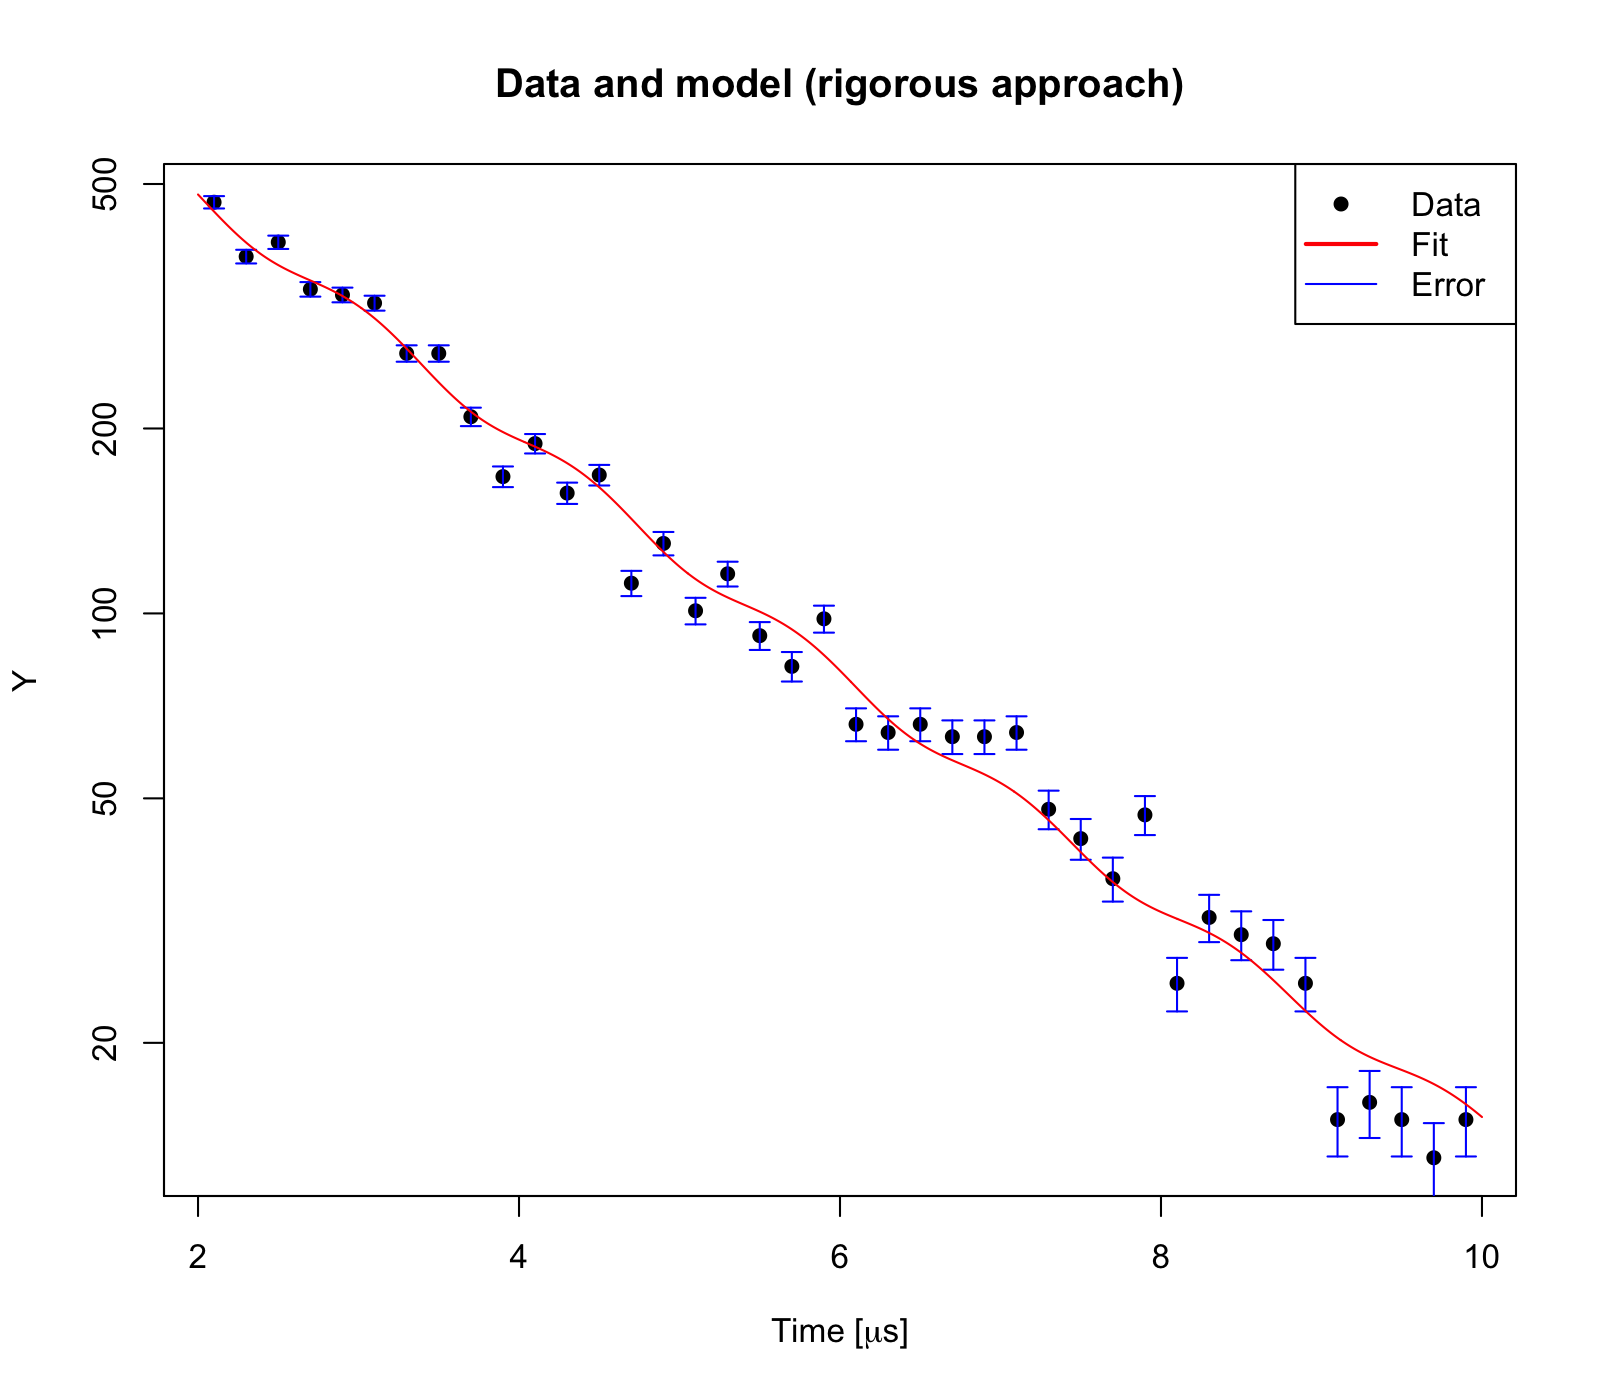

In [41]:
w <- mean(chain.df.2$w)
nmu <- mean(chain.df.2$nmu)
a <- mean(chain.df.2$a)
d <- mean(chain.df.2$d)
tau <- mean(chain.df.2$tau)
C <- mean(chain.df.2$C)

t <- seq(2, 10, length.out= 1000)
fit <- nmu*exp(-t/tau)*(1+a*cos(w*t+d))+C
errs <- sqrt(jm.input.2$Y)

plot(jm.input.2$t, jm.input.2$Y, pch = 16, col = "black", 
     xlab = expression(paste("Time [",mu,"s]")), ylab = "Y", main = "Data and model (rigorous approach)", log = 'y')

arrows(jm.input.2$t,jm.input.2$Y+errs/2,jm.input.2$t, jm.input.2$Y-errs/2,
       col='blue',angle=90,length=0.05,code=3, lwd=1)

lines(t, fit, col = "red", lwd = 1)

legend("topright", legend = c("Data", "Fit", "Error"), col = c("black", "red", "blue"), 
       pch = c(16, NA, NA), lty = c(NA, 1, 1), lwd = c(NA, 2, 1))

We can see that due to the high number of points, the model doesn't oscilate perfectly with the points, but the fit its good. When comparing the data and the model we obtain a better visual fit for low number of bins/points. Here is an example for a lower number of points fit: 

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 16
   Unobserved stochastic nodes: 5
   Total graph size: 225

Initializing model



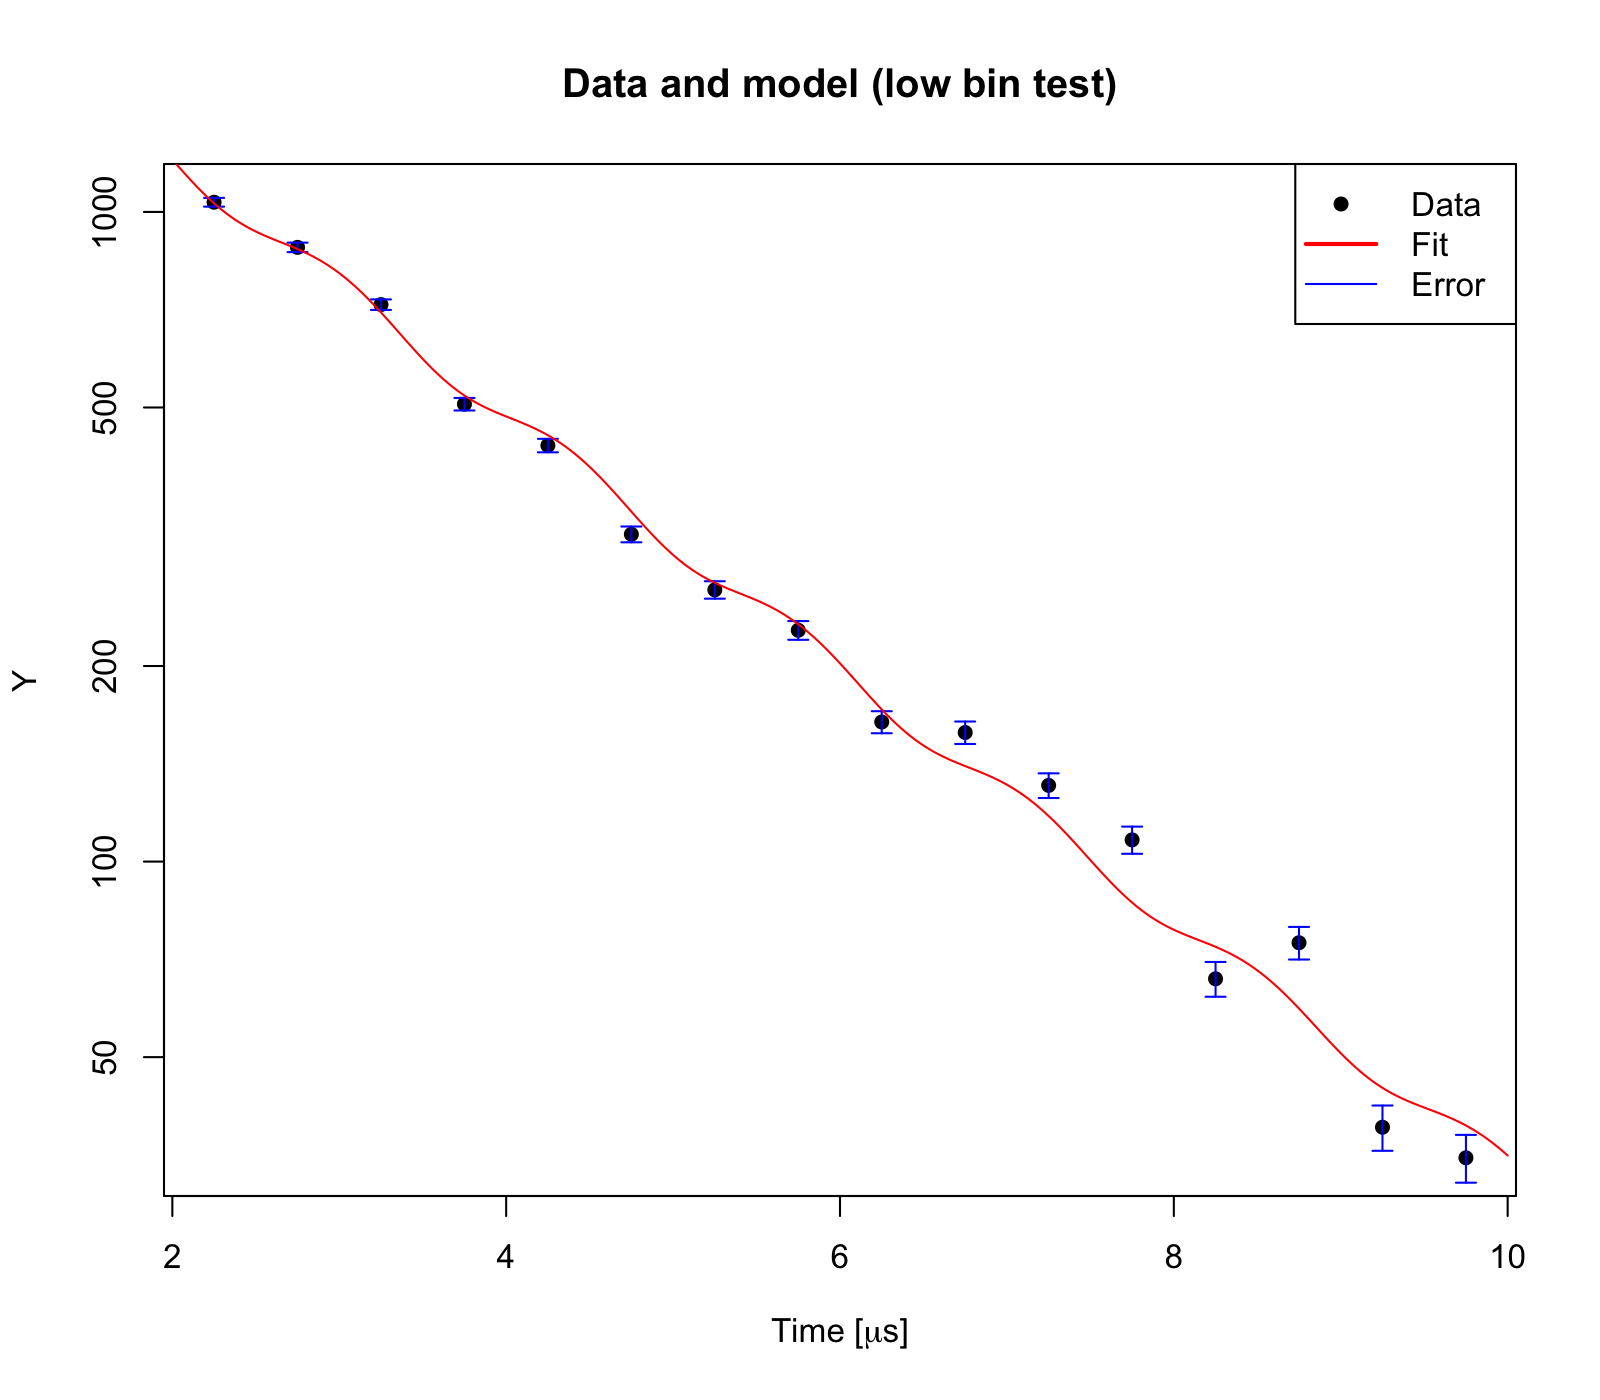

In [42]:
h.3 <- hist(r.2, breaks = 16, plot = FALSE)

jm.input.3 <- NULL
jm.input.3$t <- h.3$mids
jm.input.3$Y <- h.3$counts
jm.input.3$n <- length(h.3$mids)

jm.3 <- jags.model(textConnection(model.2), data = jm.input.3)

update(jm.3, 5000)
chain.3 <- coda.samples(jm.3, c("w","nmu", "a", "d","tau", "C"), n.iter=30000)

chain.df.3 <- as.data.frame(as.mcmc(chain.3))
w3 <- mean(chain.df.3$w)
nmu3 <- mean(chain.df.3$nmu)
a3 <- mean(chain.df.3$a)
d3 <- mean(chain.df.3$d)
tau3 <- mean(chain.df.3$tau)
C3 <- mean(chain.df.3$C)

t <- seq(2, 10, length.out= 1000)
fit <- nmu3*exp(-t/tau3)*(1+a3*cos(w3*t+d3))+C3
errs <- sqrt(jm.input.3$Y)

plot(jm.input.3$t, jm.input.3$Y, pch = 16, col = "black", 
     xlab = expression(paste("Time [",mu,"s]")), ylab = "Y", main = "Data and model (low bin test)", log = 'y')

arrows(jm.input.3$t,jm.input.3$Y+errs/2,jm.input.3$t, jm.input.3$Y-errs/2,
       col='blue',angle=90,length=0.05,code=3, lwd=1)

lines(t, fit, col = "red", lwd = 1)

legend("topright", legend = c("Data", "Fit", "Error"), col = c("black", "red", "blue"), 
       pch = c(16, NA, NA), lty = c(NA, 1, 1), lwd = c(NA, 2, 1))

We can now better observe how the model oscillates to fit the data points, specially in the (2,6) $\mu s$ range. However, for the (6,10) $\mu s$ range, the data points become noisier, making it increasingly difficult to achieve a precise fit. Despite a better visualization of the fit, a lower number of points implies losing information and a worse model.

#### 3.4 Final results

Let's now compare the results of the general and rigourous approach with magnitudes that are known in the literature, like the lifetime ($\tau$) and the g-factor of the muon with a value of 2.00233... Using the Larmor's formula, we can obtain the gyromagnetic ratio/g-factor ($g_\mu) using the results obtained for the precession in the jags run:

$$ \omega = \frac{g_\mu}{2}\frac{e}{m_\mu c} B  \hspace{0.4cm} \rightarrow  \hspace{0.4cm} g_\mu = \frac{2\omega}{B} \frac{m_\mu c}{e} $$

And will have the following error:

$$ \sigma(g_\mu) = \sqrt{\left( \frac{2}{B} \frac{m_\mu c}{e} \sigma(\omega) \right)^2 + \left( -\frac{2\omega}{B^2} \frac{m_\mu c}{e} \sigma(B) \right)^2} 
$$

We have compared the lifetime with the first general approach, and the results obtained in the first part of the project (previous), we didn't add the second rigorous approach as $\tau$ was fixed. For the g-factor we compared the true value with the results obtained in the first and second approach.
We displayed a plot were the ranges of the values are represented so you can see their compatibility. Also the compatibility coefficient for all the combinations.

LIFETIME |||  1st approach  || Mean:  2.368722 us | Standard deviation:  0.03043654 us |
LIFETIME |||    Previous    || Mean:  2.194123   us | Standard deviation:  0.02252534 us |
LIFETIME |||      True      || Mean:  2.196981 us | Standard deviation:  2.2e-06 us |
LIFETIME |||  Compatibility || 1st-True:  5.642599  | Previous-True:  0.1268811  | Previous-1st:  4.611073 | 
G-FACTOR |||  1st approach  || Mean:  1.796373 us | Standard deviation:  0.7251658  |
G-FACTOR |||  2nd approach  || Mean:  1.945935 us | Standard deviation:  0.07611572  |
G-FACTOR |||      True      || Mean:  2.002332 us | Standard deviation:  8.2e-10  |
G-FACTOR ||| Compatibility  || 1st-2nd:  0.2051189  | 1st-True:  2.70587  | 2nd-True:  0.7409355  | 


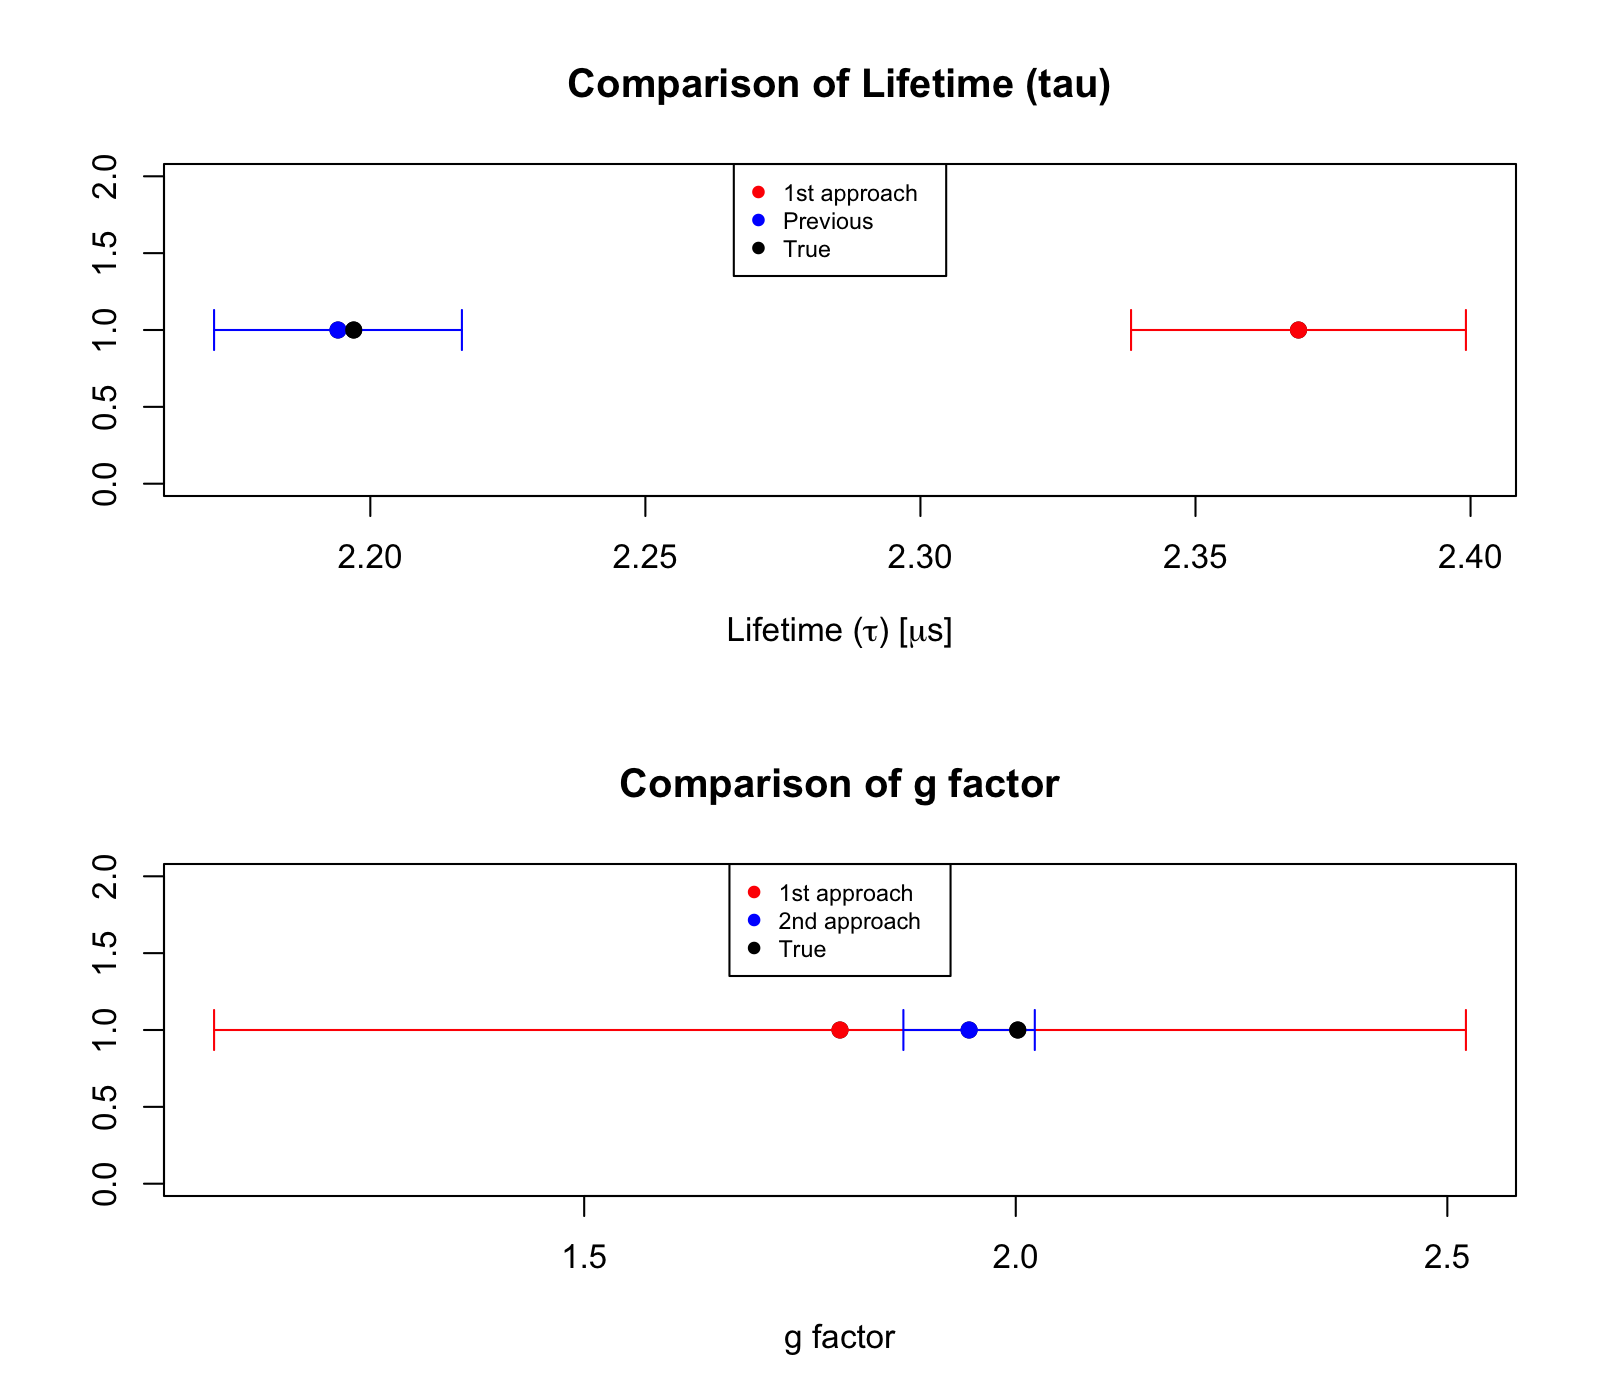

In [43]:
mean_tau1 <- mean(chain.df.gen$tau)
sd_tau1 <- sd(chain.df.gen$tau)

mean_tau_previous <- red2to10.mcT
sd_tau_previous <- red2to10.mcT.sigma

mean_tau_true <- 2.1969811
sd_tau_true <- 0.0000022

mean_g_true <- 2.00233184122
sd_g_true <- 0.00000000082

mean_B <- 0.0056
sd_B <- mean_B * 0.02

mean_g1 <- 2*mean(chain.df.gen$w)/(851.0939*mean_B)
sd_g1 <- sqrt((2*sd(chain.df.gen$w)/(851.0939*mean_B))^2 + (2*mean(chain.df.gen$w)*sd_B/(851.0939*mean_B^2))^2)

mean_g2 <- 2*mean(chain.df.2$w)/(851.0939*mean_B)
sd_g2 <- sqrt((2*sd(chain.df.2$w)/(851.0939*mean_B))^2 + (2*mean(chain.df.2$w)*sd_B/(851.0939*mean_B^2))^2)

cat("LIFETIME |||  1st approach  || Mean: ", mean_tau1, "us | Standard deviation: ", sd_tau1, "us |\n")
cat("LIFETIME |||    Previous    || Mean: ", mean_tau_previous, "  us | Standard deviation: ", sd_tau_previous, "us |\n")
cat("LIFETIME |||      True      || Mean: ", mean_tau_true, "us | Standard deviation: ", sd_tau_true , "us |\n")
cat("LIFETIME |||  Compatibility || 1st-True: ", comp(c(mean_tau1, sd_tau1), c(mean_tau_true, sd_tau_true)), 
    " | Previous-True: ", comp(c(mean_tau_previous, sd_tau_previous), c(mean_tau_true, sd_tau_true)),
    " | Previous-1st: ", comp(c(mean_tau_previous, sd_tau_previous), c(mean_tau1, sd_tau1)), "| \n")


#Once the notebooks are merged we can introduce the variables
cat("G-FACTOR |||  1st approach  || Mean: ", mean_g1, "us | Standard deviation: ", sd_g1, " |\n")
cat("G-FACTOR |||  2nd approach  || Mean: ", mean_g2, "us | Standard deviation: ", sd_g2, " |\n")
cat("G-FACTOR |||      True      || Mean: ", mean_g_true, "us | Standard deviation: ", sd_g_true, " |\n")
cat("G-FACTOR ||| Compatibility  || 1st-2nd: ", comp(c(mean_g1, sd_g1), c(mean_g2, sd_g2)), 
    " | 1st-True: ", comp(c(mean_g1, sd_g2), c(mean_g_true, sd_g_true)),
    " | 2nd-True: ", comp(c(mean_g_true, sd_g_true), c(mean_g2, sd_g2)), " | \n")


means_tau <- c(mean_tau1, mean_tau_previous, mean_tau_true)
sds_tau <- c(sd_tau1, sd_tau_previous, sd_tau_true)
labels_tau <- c("1st approach", "Previous", "True")
colors_tau <- c("red", "blue", "black")

means_g <- c(mean_g1, mean_g2,  mean_g_true)
sds_g <- c(sd_g1, sd_g2, sd_g_true)
labels_g <- c("1st approach", "2nd approach", "True")
colors_g <- c("red", "blue", "black")

par(mfrow= c(2,1))
plot(means_tau, c(1,1,1), xlim = c(min(means_tau - sds_tau), max(means_tau + sds_tau)), ylim = c(0,2),
     pch = 19, ylab = NA, xlab = expression(paste("Lifetime (",tau,") [",mu,"s]")),
     main = "Comparison of Lifetime (tau)")
for (i in 1:3) {
  points(means_tau[i],1 , pch = 19, col = colors_tau[i])
  suppressWarnings(arrows(means_tau[i] - sds_tau[i], 1, means_tau[i] + sds_tau[i], 1, angle = 90, code = 3, length = 0.1, col = colors_tau[i]))
}
legend("top", legend = labels_tau,
       col = colors_tau, pch = 19, cex=0.7)

plot(means_g, c(1,1,1), xlim = c(min(means_g - sds_g), max(means_g + sds_g)), ylim = c(0,2),
     pch = 19, ylab = NA, xlab = "g factor",
     main = "Comparison of g factor")
for (i in 1:3) {
  points(means_g[i],1 , pch = 19, col = colors_g[i])
  suppressWarnings(arrows(means_g[i] - sds_g[i], 1, means_g[i] + sds_g[i], 1, angle = 90, code = 3, length = 0.1, col = colors_tau[i]))
}
legend("top", legend = labels_g, cex= 0.7,
       col = colors_g, pch = 19)

Let's analyze the results:

For the lifetime, we can see as expected, that the value obtained from the first part of the project has a narrower error and is compatible with the true value. Contrarily, the range obtained using the general approach is not compatible with the other two measurements, resulting in high compatibility coefficients (around 4–6), indicating poor compatibility and an overal off value with respect to the exact one. Highliting the poor performance of the first model.

For the g-factor, although the value from the first approach is technically compatible with the true value, this is largely due to its very wide standard deviation, with a relative uncertainty of about $\frac{\sigma(g)}{\overline{g}} \sim 40 \%$. If we instead examine the compatibility coefficient (2.8), we see that it still reflects poor compatibility. However, the value from the second and more rigorous approach is both compatible and close to the true value, indicating a more precise and reliable measurement.

These observations demonstrate the improvement from the first, more general approach to the second, more refined one.

Let's plot now the distributions obtained for the precession: the first distribution, the second and more refined one, and the one obtained with known values from the literature and the value of the magnetic field.

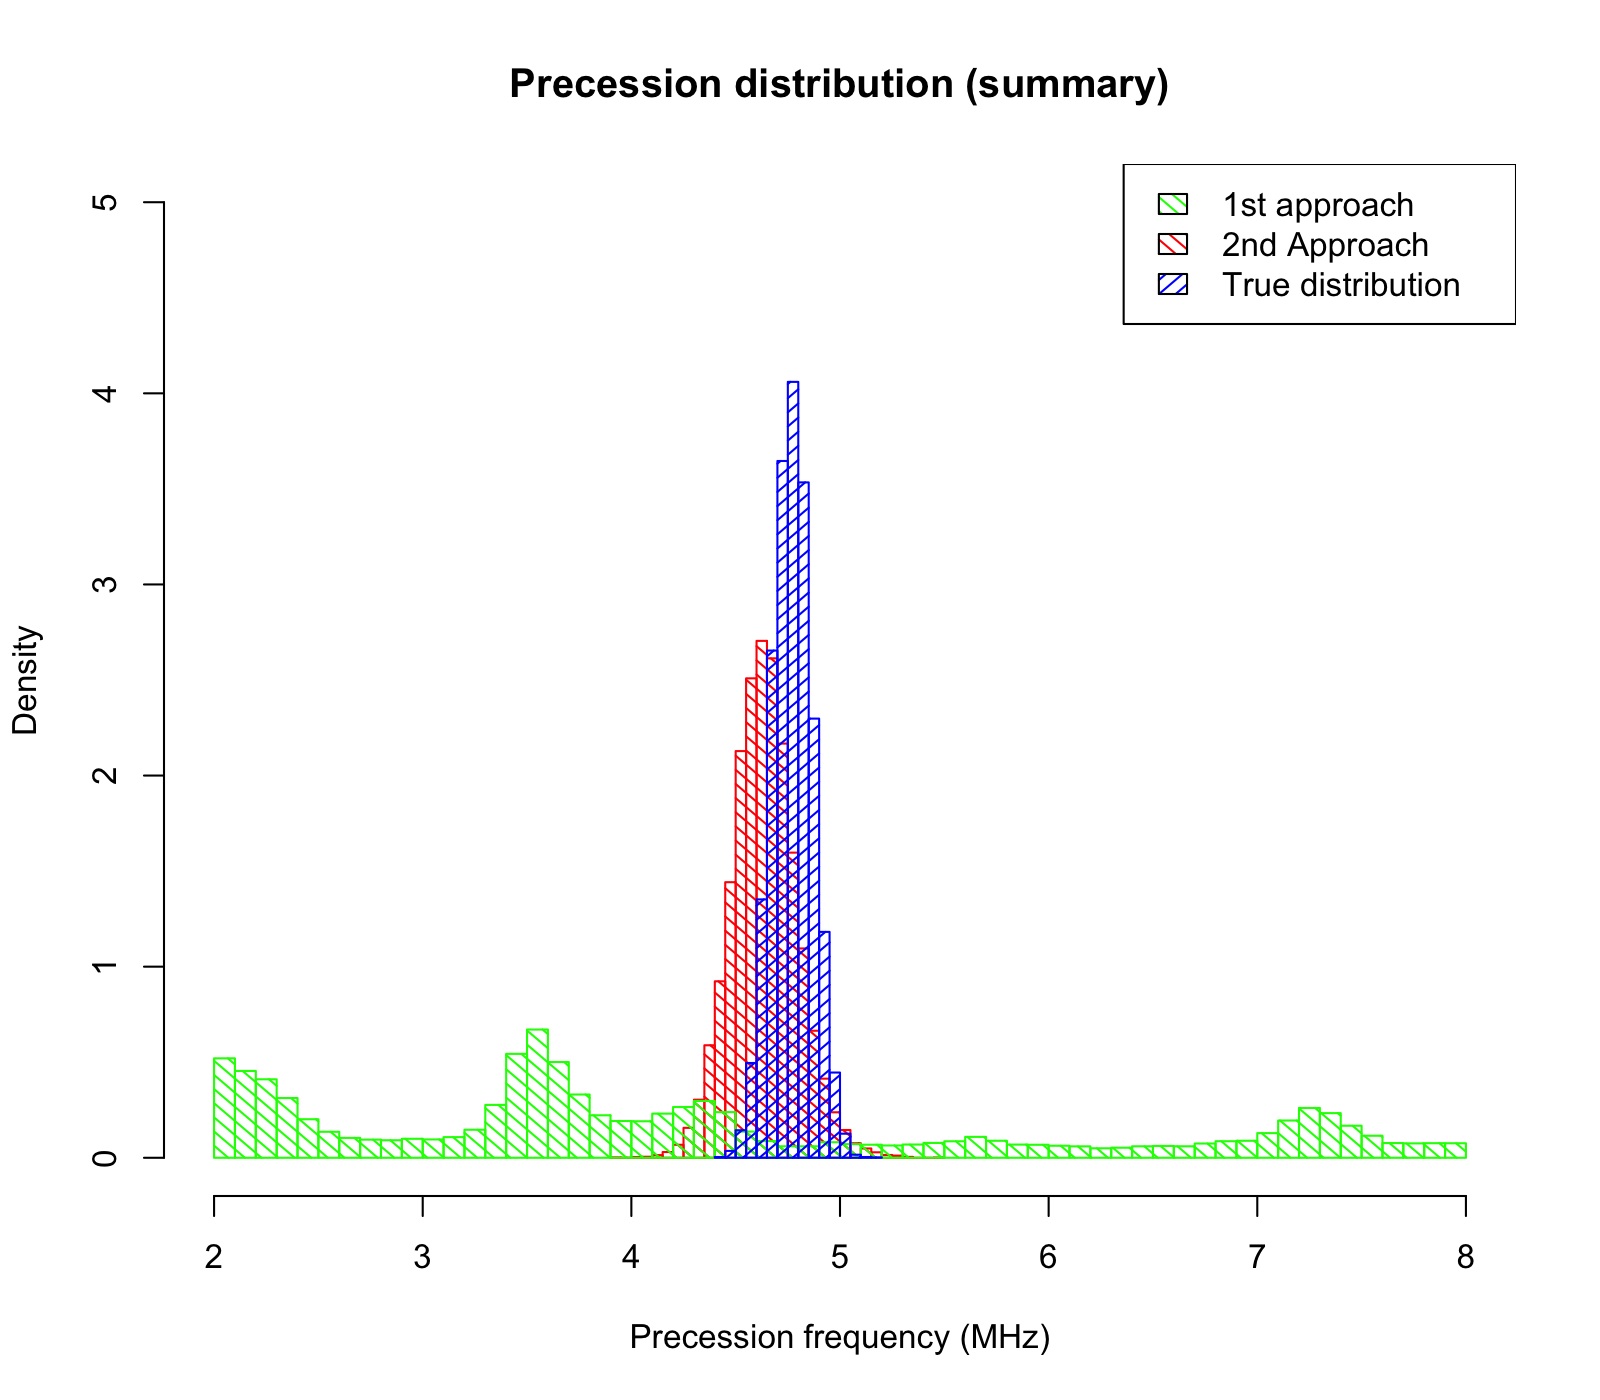

In [44]:
# finally comparison
h2 <- hist(chain.df.2$w, xlim=c(2,8), prob=T, breaks=30, density=20, angle=-45, col='red', 
     main = "Precession distribution (summary)", xlab = "Precession frequency (MHz)",  ylim = c(0,5))

hist(chain.df.gen$w, xlim=c(2,8), prob=T, breaks=60, density=20, angle=-45, col='green', add= T)

true.gmu_2 <- (2.0023318418/2.)
true.w.mean <- 4.766*true.gmu_2
true.w.sd <- true.gmu_2*851.0939*sd_B


hist(rnorm(10000, true.w.mean, true.w.sd), breaks=20, add=T, prob=T, col='blue', density=20)

legend("topright", legend = c("1st approach", "2nd Approach", "True distribution"), 
       fill = c("green", "red", "blue"),  density = c(20, 20, 20), 
       angle = c(-45, -45, 45), col = c('green', 'red', 'blue'))

Although the 2nd approach is not completely aligned with the expected distribution due to imperfections on the experiment or noise, the improvement compared to the first distribution is substantial, as the initial one was far from resembling a Gaussian.

### 3. Bibliography

[1] S. Navas et al, (Particle Data Group), Phys. Rev. D 110 (2024) 03001 https://pdglive.lbl.gov/Particle.action?node=S004&init=0

[2] C. Amsler, <i>The determination of the muon magnetic moment from cosmic rays</i>, American Journal of Physics, 42 (1974) 12.

[3] D. Bosnar emphet al., <i>A simple setup for the determination of the cosmic muon magnetic moment</i>, American Journal of Physics, 90 (2022) 8

[4] Melissinos, A. C. 1., & Napolitano, J. (2003). <i>Experiments in modern physics. 2nd ed.</i>, San Diego, Academic Press.

[5] Technische Universität Dresden, <i>Lifetime of muons: laboratory experiment</i>, https://tu-dresden.de/mn/physik/iktp/ressourcen/dateien/studium/praktikum/LM_English.pdf?lang=de